# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')
import access_functions as af
import subphase_calc_functions as subphase_calc
import access_plot_functions as apf
import load_dataset as load
import phase_calc_functions as phase_calc
import subphase_calc_2 as sub2
import rank_histograms as rh

import miscellaneous as misc

In [2]:
import rank_hist_monthly as rhm
import rank_hist_plots_monthly as rhpm
import rank_hist_plots as rhp

In [3]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables()

4159 4159
4159 4159


# Raintype

In [204]:
# This way you don't have to reload all of the datasets if you want to reset them
awap_init = awap.copy(deep = True)
access_init = access.copy(deep = True)

In [205]:
awap = awap_init
access = access_init

In [206]:
import subphase_calc_functions as scf

In [207]:
q = 90

# If q > 0, then awap will be the events above a certian percentile
if q:
    awap = scf.unsplit_find_events_above_q(awap, q)
    
    # Looping through ensemble
    ex_stor = []
    for ensemble in access.ensemble.values:  
        # Selecting a single ensemble
        access_single = access.sel(ensemble = ensemble)
        # Getting extrreme events
        access_90_single = scf.unsplit_find_events_above_q(access_single, q)
        
        ex_stor.append(access_90_single)
    access = xr.concat(ex_stor, pd.Index(access.ensemble.values, name = 'ensemble'))
    
else:
    q = 'all'

In [208]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [209]:
subphase_calc = reload(subphase_calc)
# Split access into the subphases: enhanced, suppressed, transition and inactive.
access_split = af.access_rmm_split(access, rmm_access)

1 2 3 4 5 6 7 8 9 10 11 

MemoryError: Unable to allocate 4.87 GiB for an array with shape (11, 4, 4066, 49, 149) and data type float32

# Functions

In [ ]:
def rank_create(obs, model, function):
    
    # This function calculates all the ranks of the ensembles compared to awap. This can
    # take any function
    
    
    # Resamples by year and month, then applying functoin to this subgroup
    access_y = model.groupby('time.month').apply(function)
    awap_y = obs.groupby('time.month').apply(function)
    
    
    ens_stor = []
    
    ensembles = access_y.ensemble.values
    
    
    for ensemble in ensembles:
        
        # Getting a single ensemble
        access_single = access_y.sel(ensemble = ensemble)
        
        # Getting where the model and the observations both have values
        access_single = access_single.where(awap_y > 0)
        awap_y = awap_y.where(awap_y > 0)
        
        # All the different months when AWAP is greater
        awap_greater = awap_y.where(awap_y >= access_single)
        
        
        ens_stor.append(awap_greater)
        
    awap_greater = xr.concat(ens_stor, pd.Index(ensembles, name = 'ensemble'))
    
    # Conting all of the instances when AWAP is greater
    rank = awap_greater.count(dim = 'ensemble')
    
    rank['precip'] = rank.precip + 1
    
    return rank
        

In [ ]:
# This can take in any resample data set, where model is the different ensemble members
def rank_create_2(awap_y, access_y):
    

        
    
    ens_stor = []
    
    ensembles = access_y.ensemble.values
    
    
    for ensemble in ensembles:
        
        # Getting a single ensemble
        access_single = access_y.sel(ensemble = ensemble)
        
        # Getting where the model and the observations both have values
        access_single = access_single.where(awap_y > 0)
        awap_y = awap_y.where(awap_y > 0)
        
        # All the different months when AWAP is greater
        awap_greater = awap_y.where(awap_y >= access_single)
        
        
        ens_stor.append(awap_greater)
        
    total_greater = xr.concat(ens_stor, pd.Index(ensembles, name = 'ensemble'))
    
    # Conting all of the instances when AWAP is greater
    rank = total_greater.count(dim = 'ensemble')
    
    rank['precip'] = rank.precip + 1
    

    
    return rank
        

In [ ]:
def ranks_to_rel_freq(rank):
    
    # These are all the different ranks that I need to calculate the frequency for
    bins = np.unique(rank.precip.values)

    freq_stor = []

    for bin_ in bins:
        
        # Getting just the data of a single rank
        rank_single  = rank.where(rank.precip == bin_, drop = True)

        # Counting how many times that rank occurs
        freq = rank_single.count(dim = 'year')

        freq_stor.append(freq)

    # We now have file of all the frequencies
    freqs = xr.concat(freq_stor, pd.Index(bins, name =  'rank_'))
    
    # Now need to convert to a relative frequency by dividing by the total number of frequencies
    div  = freqs.sum(dim = 'rank_')
    rel_freq = freqs/div
    
    # Renaming the dimension to a more apt name
    rel_freq = rel_freq.rename({'precip':'frequency'})
    
    return rel_freq

In [ ]:
def ranks_to_rel_freq_2div(rank_tot):
    
    month_groups = [[10,11,12],[1,2,3]]
    month_stor = []
    
    for months in month_groups:
    
        rank = rank_tot.sel(month = months)
        # These are all the different ranks that I need to calculate the frequency for
        bins = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12]

        freq_stor = []

        for bin_ in bins:

            # Getting just the data of a single rank
            rank_single  = rank.where(rank.precip == bin_, drop = True)

            # Counting how many times that rank occurs
            freq = rank_single.count(dim = 'year').sum(dim = 'month')

            freq_stor.append(freq)

        # We now have file of all the frequencies
        freqs = xr.concat(freq_stor, pd.Index(bins, name =  'rank_'))

        # Now need to convert to a relative frequency by dividing by the total number of frequencies
        div  = freqs.sum(dim = 'rank_')
        rel_freq = freqs/div

        # Renaming the dimension to a more apt name
        rel_freq = rel_freq.rename({'precip':'frequency'})
        
        month_stor.append(rel_freq)
        
        
    rel_freq_tot = xr.concat(month_stor, pd.Index(['early','late'], name = 'month'))
    
    return rel_freq_tot

In [ ]:
# This calculates the frequnecy of the ranks across time and space, rather than just time
def ranks_to_rel_freq_2div_total(rank_tot):
    
    month_groups = [[10,11,12],[1,2,3]]
    month_stor = []
    
    for months in month_groups:
    
        rank = rank_tot.sel(month = months)
        # These are all the different ranks that I need to calculate the frequency for
#         bins = np.unique(rank.precip.values)
        bins = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12]

        freq_stor = []

        for bin_ in bins:

            # Getting just the data of a single rank
            rank_single  = rank.where(rank.precip == bin_, drop = True)

            # Counting how many times that rank occurs
            freq = rank_single.count(dim = ['year','lat','lon','month'])

            freq_stor.append(freq)

        # We now have file of all the frequencies
        freqs = xr.concat(freq_stor, pd.Index(bins, name =  'rank_'))

        # Now need to convert to a relative frequency by dividing by the total number of frequencies
        div  = freqs.sum(dim = 'rank_')
        rel_freq = freqs/div

        # Renaming the dimension to a more apt name
        rel_freq = rel_freq.rename({'precip':'frequency'})
        
        month_stor.append(rel_freq)
        
        
    rel_freq_tot = xr.concat(month_stor, pd.Index(['early','late'], name = 'month'))
    
    return rel_freq_tot

In [ ]:
def calc_argmax(data):
    argmax = data.frequency.argmax(dim = 'rank_')
    argmax = argmax + 1
    argmax = argmax.to_dataset(name = 'argmax_')
    argmax = misc.apply_masks(argmax)
    return argmax

# Anomaly Calculation

In [ ]:
import access_general_functions as access_general

import access_correlation_functions as access_corr

<b> RMM Count 

In [ ]:
access_general = reload(access_general)
rmm_count_obs  = access_general.count_in_rmm_subphase_year_month_resample(rmm_obs)

<b> AWAP anomalies

In [ ]:
# Count
access_corr = reload(access_corr)
count_anom = access_corr.count_month_year_anomalies(awap_split, awap, rmm_count_obs)

# Sum
access_corr = reload(access_corr)
sum_anom = access_corr.sum_month_year_anomalies(awap_split, awap, rmm_count_obs)

# Mean
access_corr = reload(access_corr)
mean_anom = access_corr.mean_month_year_anomalies(awap_split, awap, rmm_count_obs)

<b> ACCESS anomlies

In [ ]:
# Count
access_general = reload(access_general)
access_corr = reload(access_corr)
count_anom_ens, count_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.count_month_year_anomalies)

# Sum
access_general = reload(access_general)
access_corr = reload(access_corr)
sum_anom_ens, sum_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.sum_month_year_anomalies)

# Mean
access_general = reload(access_general)
access_corr = reload(access_corr)
mean_anom_ens, mean_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.mean_month_year_anomalies)

# Rank Calculation

<b> Finding the ranks

In [ ]:
def all_rank_info(obs, mod):
    
    rank = rank_create_2(obs, mod)
    
    # Removing the points, where the model and the the observation don't have any rainfall
    # If not removed then these points become rank 1
    # 999 is used instread of nan as its slows down, but doesn't alter the value of, subsequency calculation
    rank = rank.where(np.logical_and(obs.precip > 0,
                                             mod.sum(dim = 'ensemble').precip > 0),999)
    
    # The 2div indicates this is for early and late wet season
    # THis is the relative fequency of all ranks
    rel_freq = ranks_to_rel_freq_2div(rank)
    
    
    # Same thing as above, byt for all lat and lon is collapsed
    rel_freq_total  = ranks_to_rel_freq_2div_total(rank)
    
    return rank, rel_freq, rel_freq_total

In [ ]:
# count
rank_count, rel_freq_count, rel_freq_total_count = all_rank_info(count_anom, count_anom_ens)

In [ ]:
# sum
rank_sum, rel_freq_sum, rel_freq_total_sum = all_rank_info(sum_anom, sum_anom_ens)

In [ ]:
# mean
rank_mean, rel_freq_mean, rel_freq_total_mean = all_rank_info(mean_anom, mean_anom_ens)

## Plots

In [ ]:
savedir = '../images/access/rank_histogram/'

### Total Bar Plots

In [ ]:
rhpm = reload(rhpm)
month = 'early'

In [ ]:
save_name = f'count_{q}_{month}_total'
data = rel_freq_total_count.sel(month = month)
rhpm.generate_phase_hist(data, save_name = save_name ,savedir = savedir)

In [ ]:
for data,raintype in zip([rel_freq_total_count, rel_freq_total_sum ,rel_freq_total_mean],['count','sum','mean']):
    for month in ['early','late']:
        save_name = f'{raintype}_{q}_{month}_total'
        subdata = data.sel(month = month)
        rhpm.generate_phase_hist(subdata, save_name = save_name ,savedir = savedir)

### Maps

In [ ]:
rhpm = reload(rhpm)

phase = 'inactive'
month = 'late'


save_name = f"count_maps_{q}_{phase}_{month}"
single_phase = rel_freq_count.sel(phase = phase, month = month)
rhpm.rank_maps(single_phase, save_name = save_name, savedir = savedir)

### Argmax

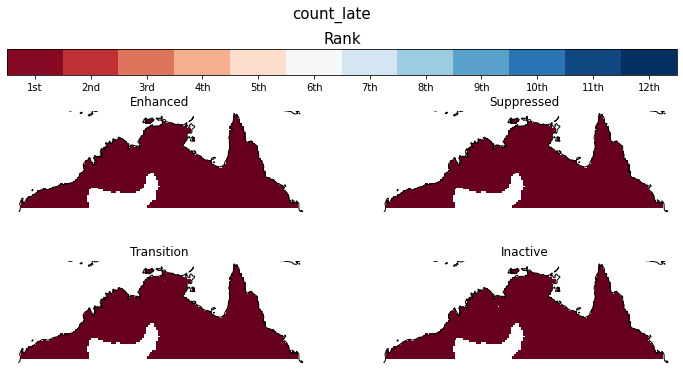

In [41]:
rhpm = reload(rhpm)
month = 'late'
savetitle = f'count_{month}'
rhpm.argmax_map_plot(argmax_count.sel(month = month), savetitle = savetitle)#, savedir = savedir_count_2)

# Count

In [175]:
# Thses cells are not to be run below
assert 1 == 0

AssertionError: 

## Calculation

In [15]:
savedir_count = 'plots_2/rank_hist/count/'

Getting all the ranks for each year

In [73]:
function = group_resample_count
rank = rank_create(awap_split, access_split, function)

Converting all of the ranks of each year into a relative frequency

In [18]:
# The 2div indicates this is for early and late wet season
rel_freq = ranks_to_rel_freq_2div(rank)

In [19]:
rel_freq 

<xarray.Dataset>
Dimensions:    (lat: 49, lon: 149, month: 2, phase: 4, rank_: 12)
Coordinates:
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * rank_      (rank_) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * phase      (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month      (month) object 'early' 'late'
Data variables:
    frequency  (month, rank_, phase, lat, lon) float64 1.0 0.8696 ... 0.0 0.0

<b> The frequnecy across all lat and lon </b>

In [39]:
# The 2div indicates this is for early and late wet season
rel_freq_total = ranks_to_rel_freq_2div_total(rank)

rel_freq_total

<xarray.Dataset>
Dimensions:    (month: 2, phase: 4, rank_: 12)
Coordinates:
  * rank_      (rank_) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * phase      (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month      (month) object 'early' 'late'
Data variables:
    frequency  (month, rank_, phase) float64 0.7777 0.8309 ... 0.03671 0.02814

<b> Lower and Upper is splitting the frequnecy into the lower and upper lat halves of Australia, as they ar different histograms </b>

In [109]:
rank = rank.astype(float)

In [167]:
misc = reload(misc)
ranks = misc.apply_masks_ranks(rank)

In [170]:
# The 2div indicates this is for early and late wet season
rel_freq_total_upper = ranks_to_rel_freq_2div_total(rank.sel(lat = slice(-19, 0)))

rel_freq_total_upper 

<xarray.Dataset>
Dimensions:    (month: 2, phase: 4, rank_: 12)
Coordinates:
  * rank_      (rank_) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * phase      (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month      (month) object 'early' 'late'
Data variables:
    frequency  (month, rank_, phase) float64 0.8063 0.8495 ... 0.05055 0.02777

In [171]:
# The 2div indicates this is for early and late wet season
rel_freq_total_lower = ranks_to_rel_freq_2div_total(rank.sel(lat = slice(-25, -19)))

rel_freq_total_lower 

<xarray.Dataset>
Dimensions:    (month: 2, phase: 4, rank_: 12)
Coordinates:
  * rank_      (rank_) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * phase      (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month      (month) object 'early' 'late'
Data variables:
    frequency  (month, rank_, phase) float64 0.704 0.7776 ... 0.1004 0.0652

<b> Calculating the rank with the greatest frequency

In [ ]:
argmax = calc_argmax(rel_freq)

In [22]:
savedir = 'plots_3/rank_hist/'

## Total Bar Plots

In [ ]:
savedir_total = savedir + 'total_bar/'

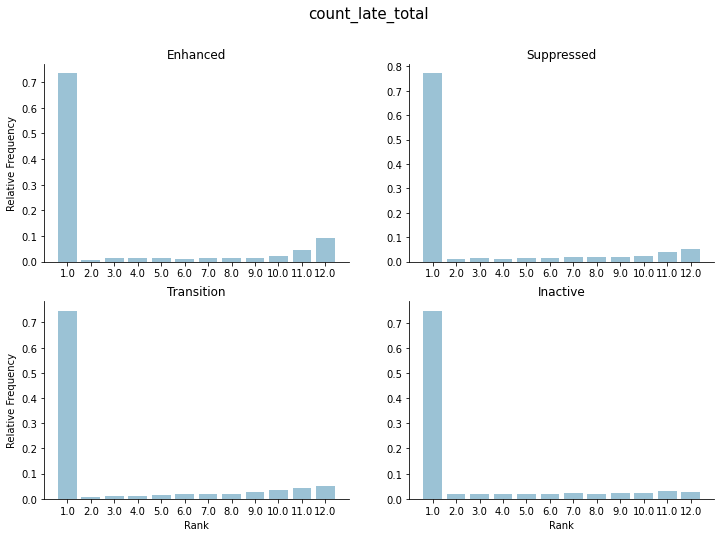

In [172]:
rhpm = reload(rhpm)
month = 'late'


save_name = f'count_{month}_total'
data = rel_freq_total_upper.sel(month = month)
rhpm.generate_phase_hist(data, save_name = save_name)# ,savedir = savedir_total)

## Single Bar Plots

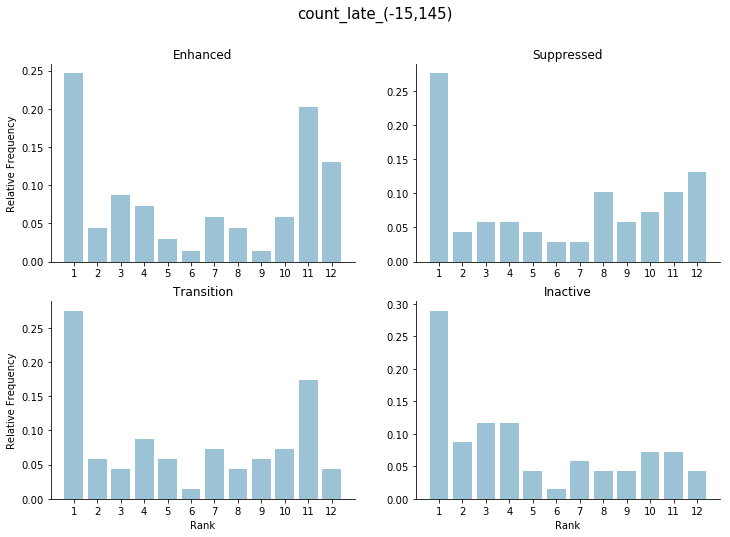

In [42]:
rhpm = reload(rhpm)
month = 'late'
lat = -15
lon = 145

save_name = f'count_{month}_({lat},{lon})'
data = rel_freq.sel(month = month, lat = lat, lon = lon)
rhpm.generate_phase_hist(data,  savedir = savedir + 'bar_plots/', save_name = save_name)

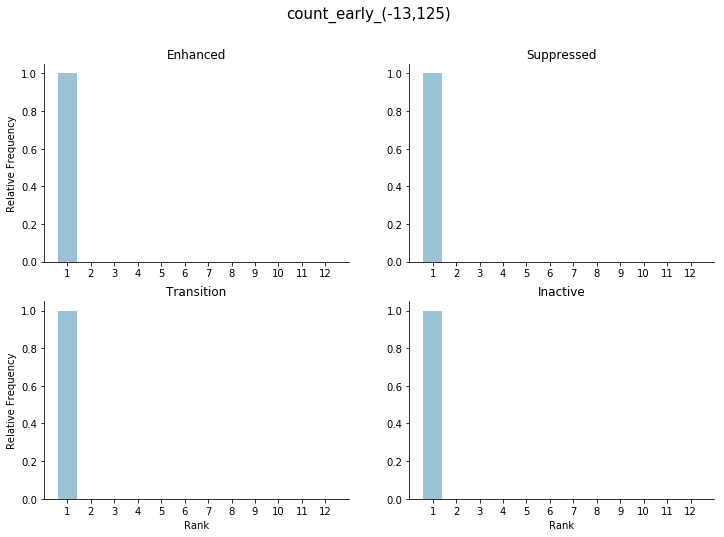

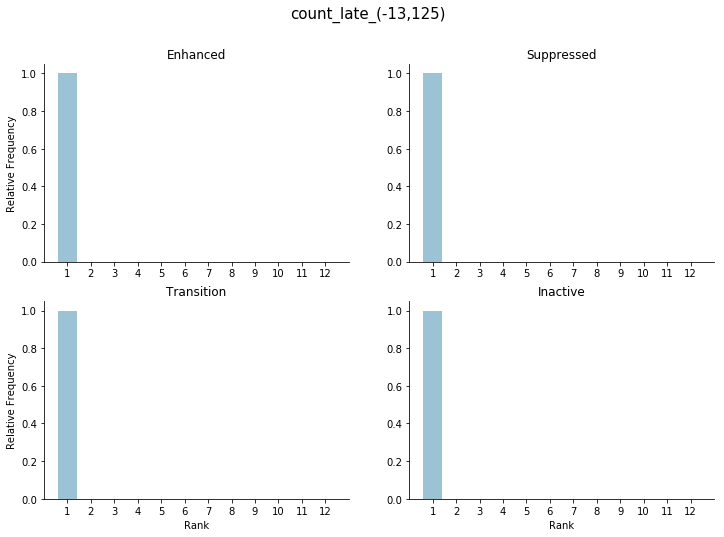

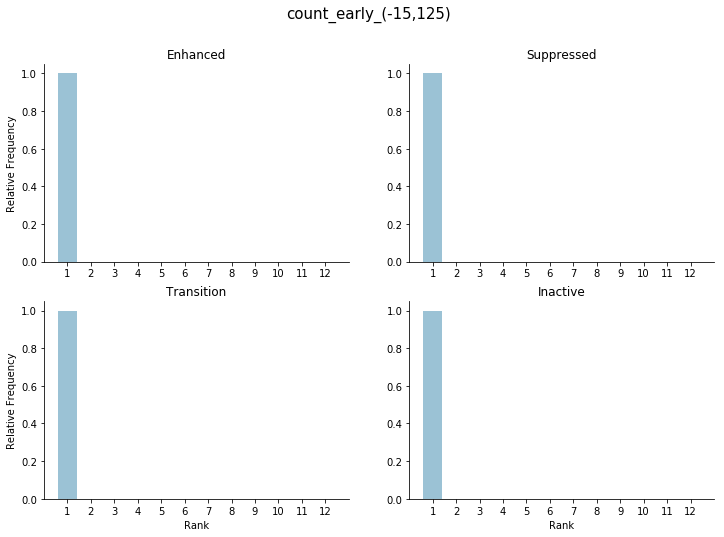

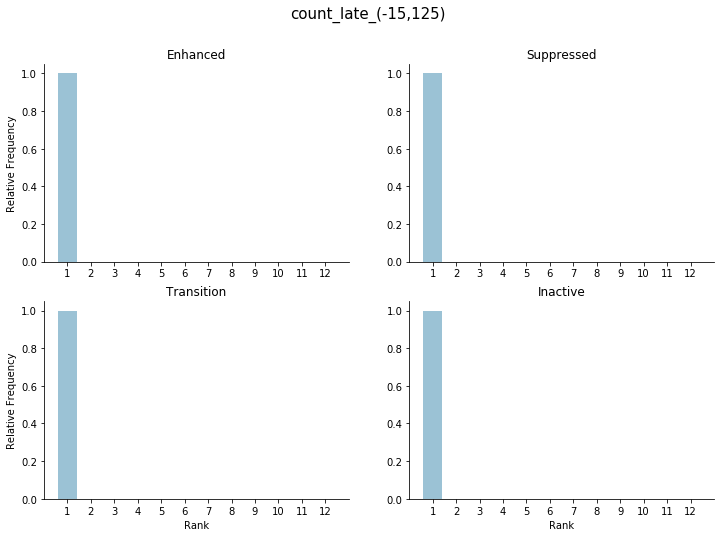

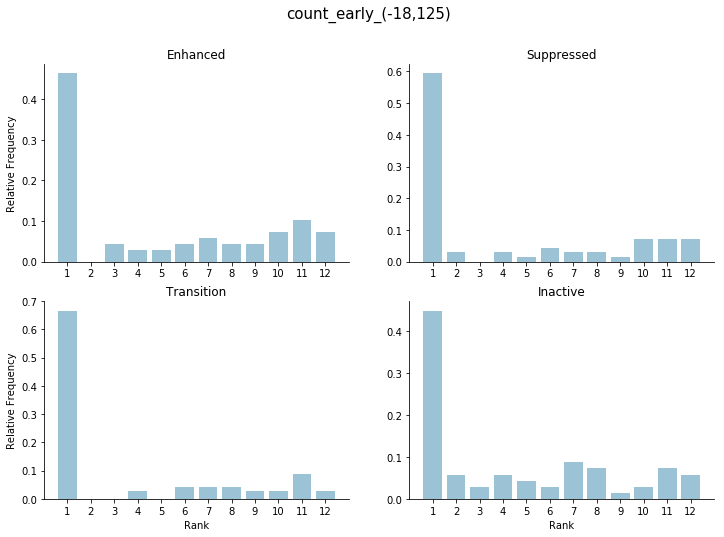

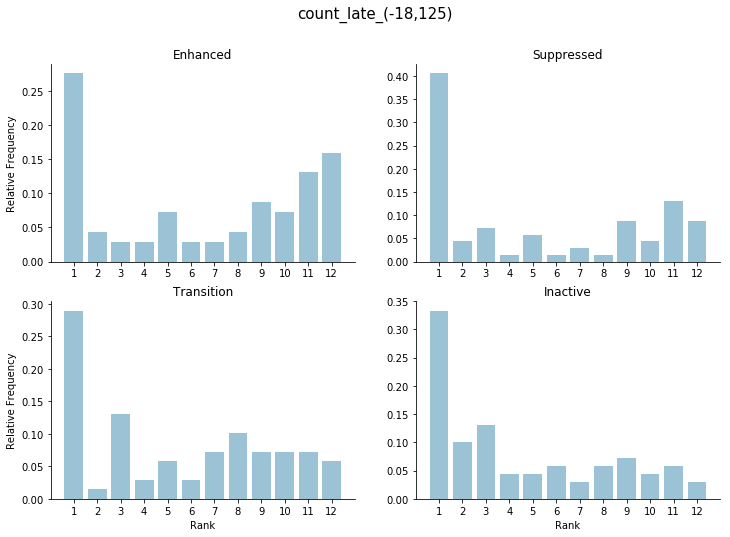

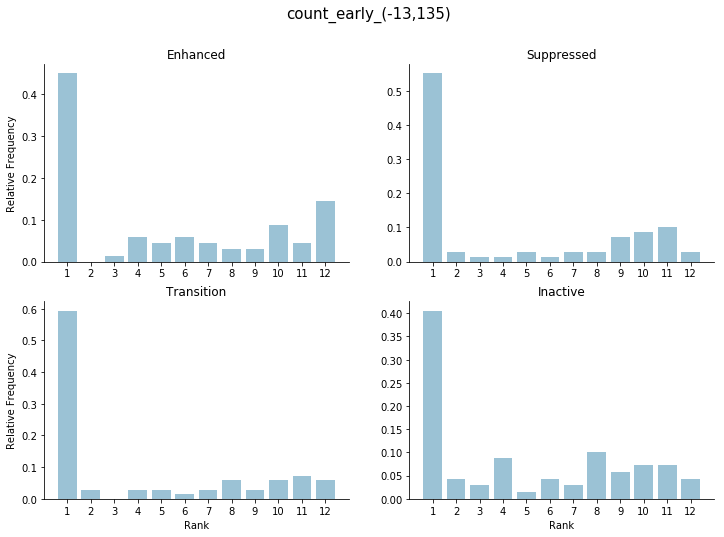

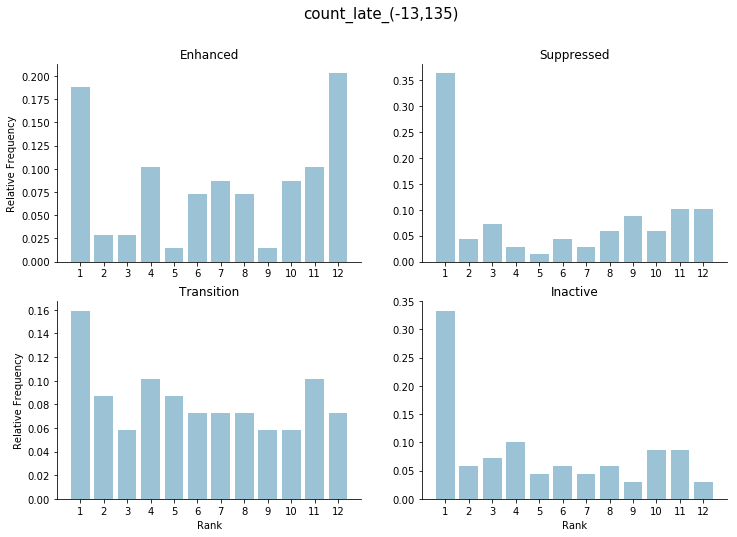

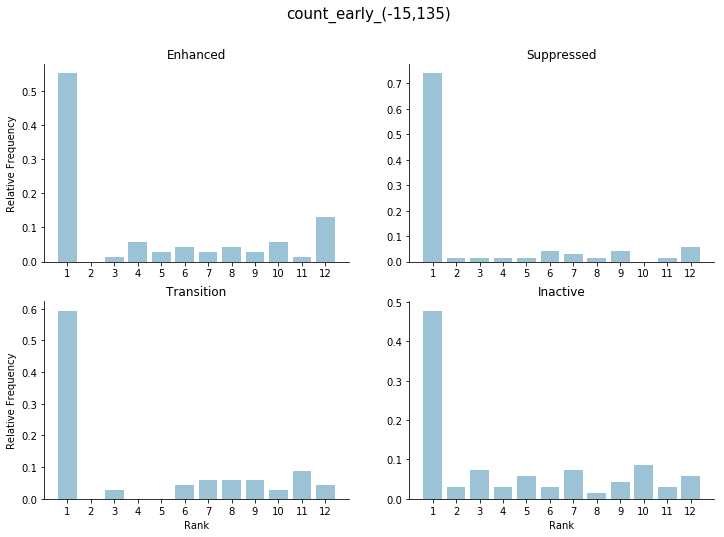

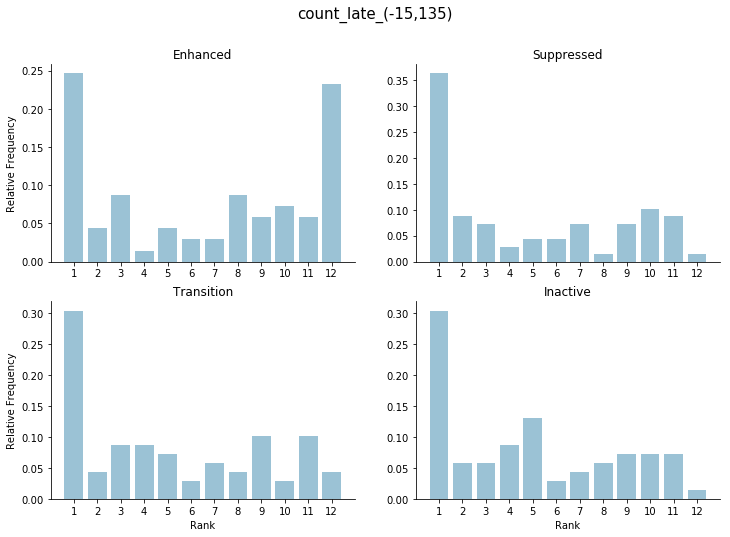

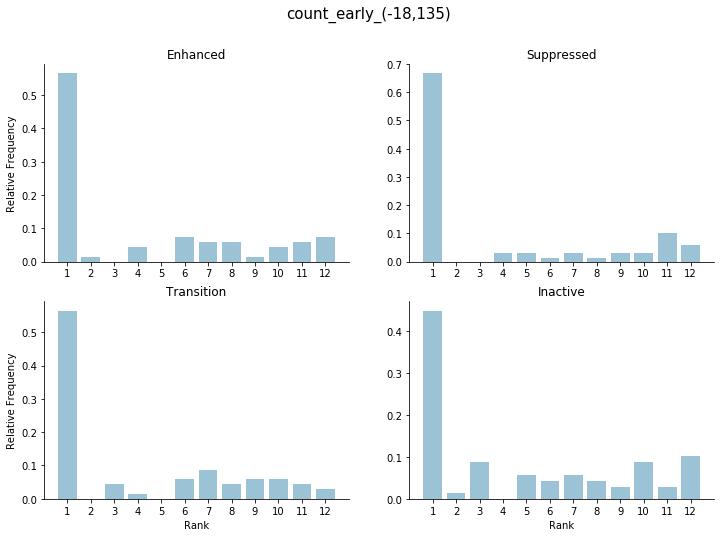

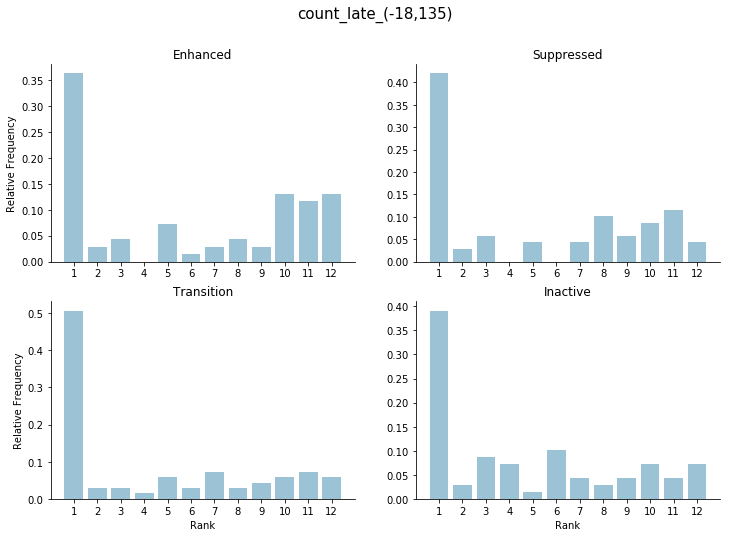

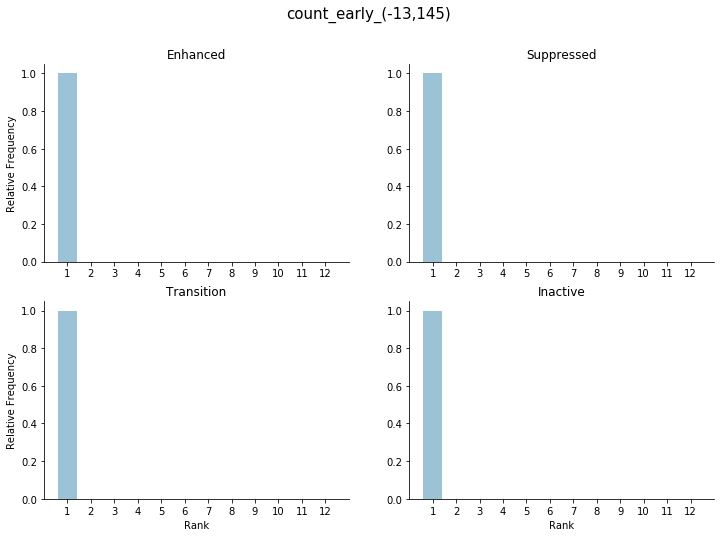

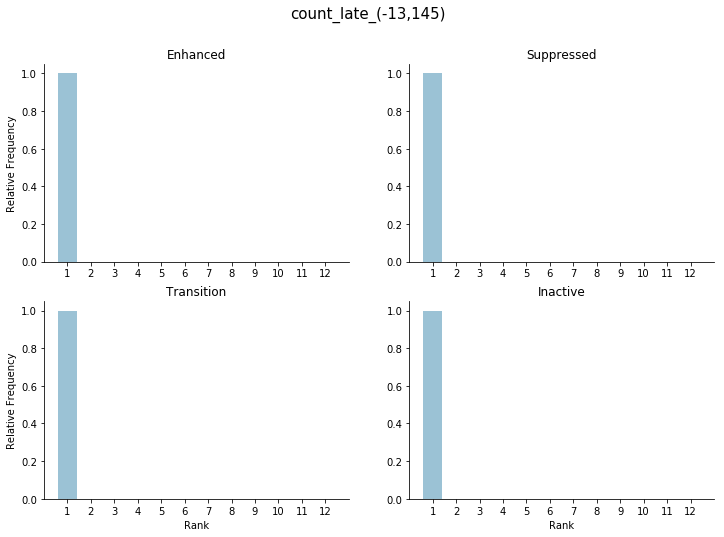

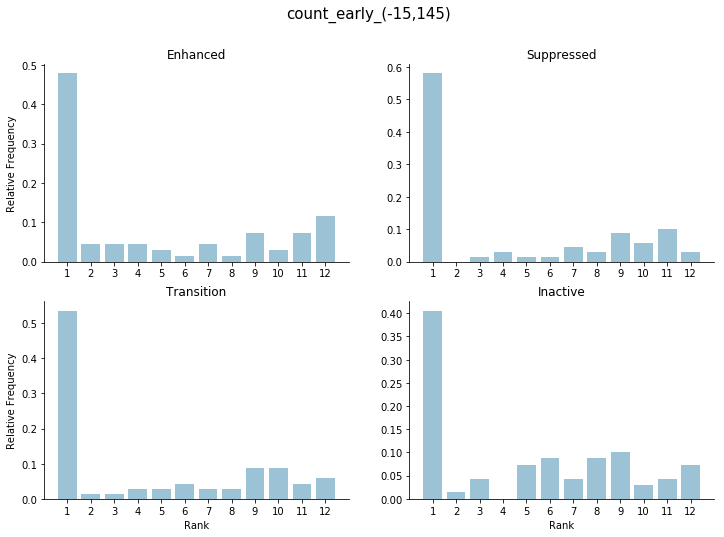

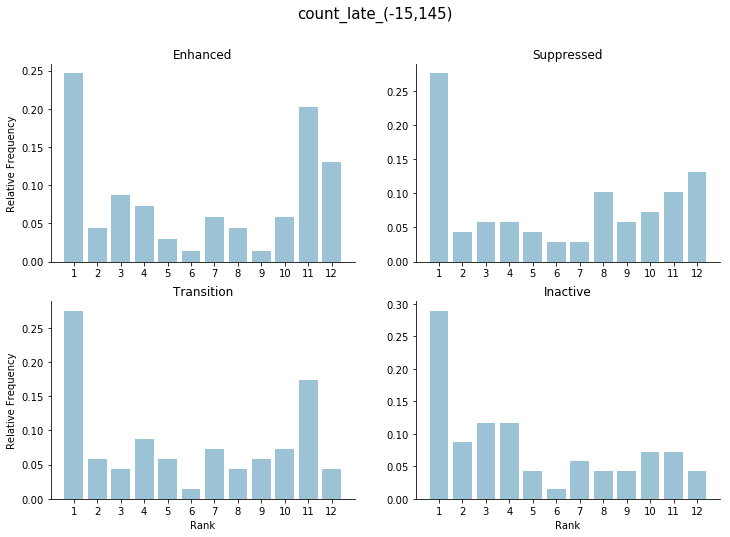

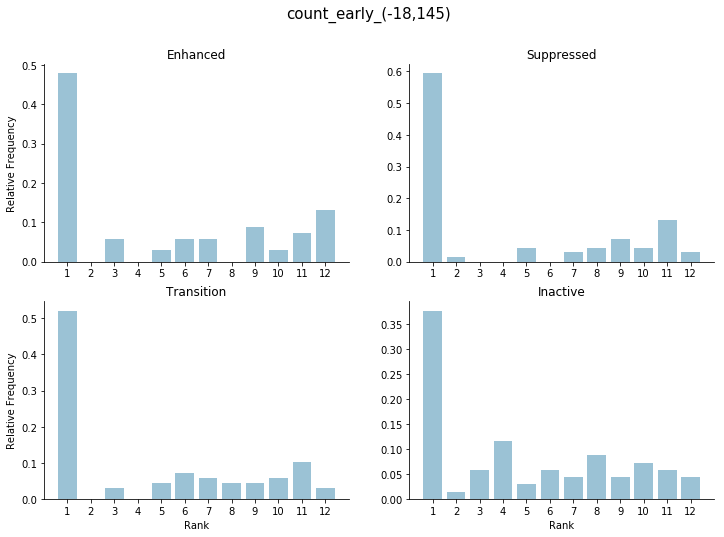

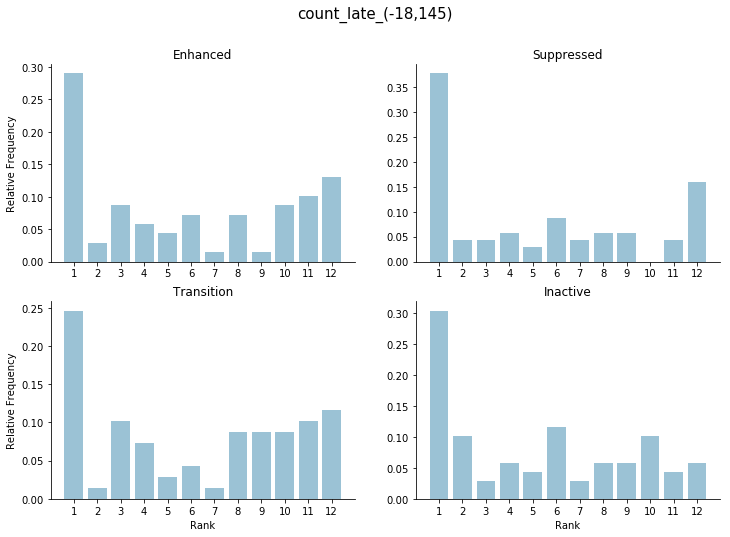

In [44]:
for lon in [125,135,145]:
    for lat in [-15,-18]:
        for month in ['early','late']:
            save_name = f'count_{month}_({lat},{lon})'
            data = rel_freq.sel(month = month, lat = lat, lon = lon)
            rhpm.generate_phase_hist(data,  savedir = savedir + 'bar_plots/', save_name = save_name)

## Maps

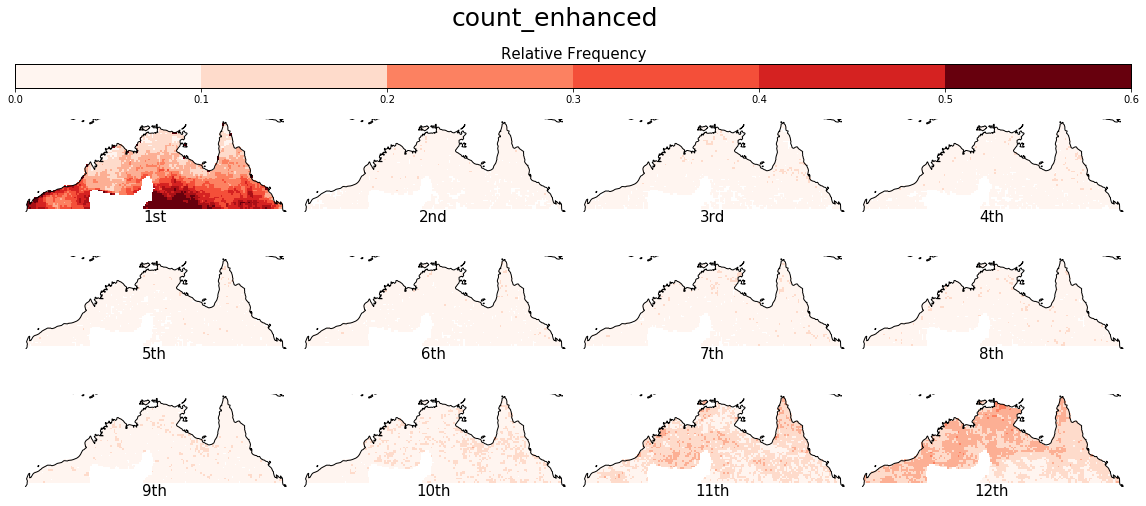

In [32]:
rhpm = reload(rhpm)

phase = 'enhanced'
month = 'late'


save_name = f"count_{phase}"
single_phase = rel_freq.sel(phase = phase, month = month)
rhpm.rank_maps(single_phase, save_name = save_name)

In [49]:
savedir_count_1 = savedir + 'maps/'

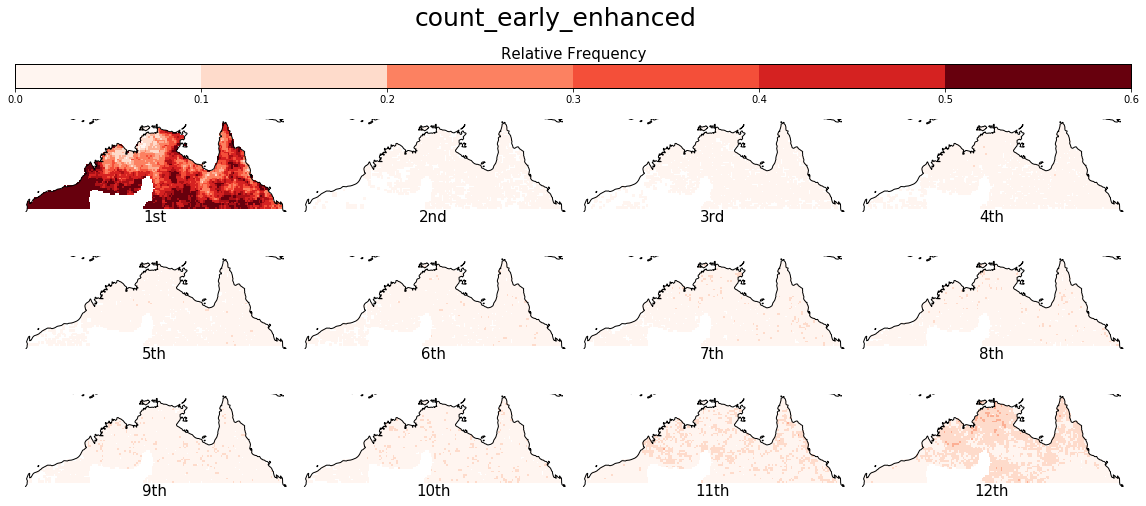

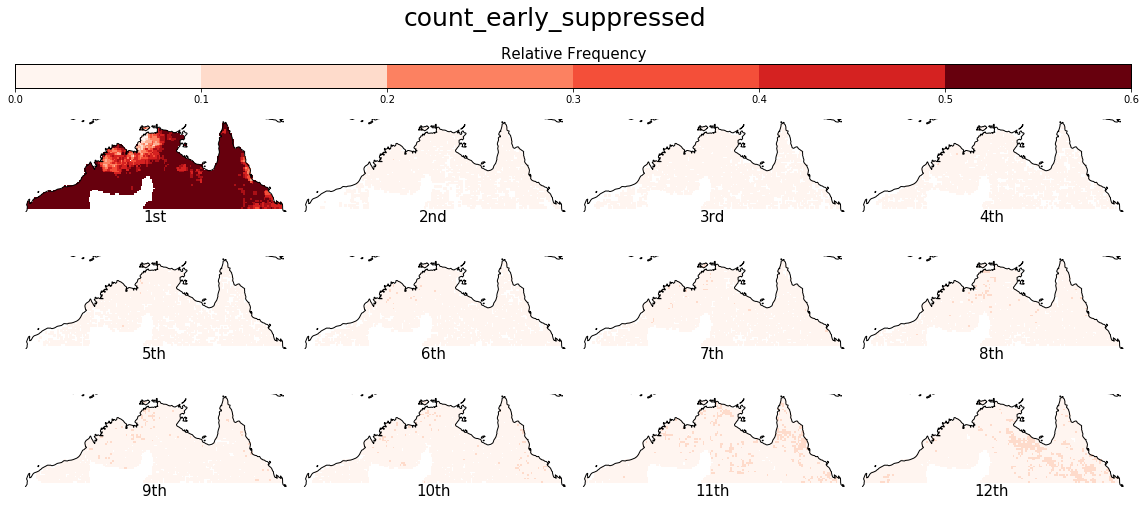

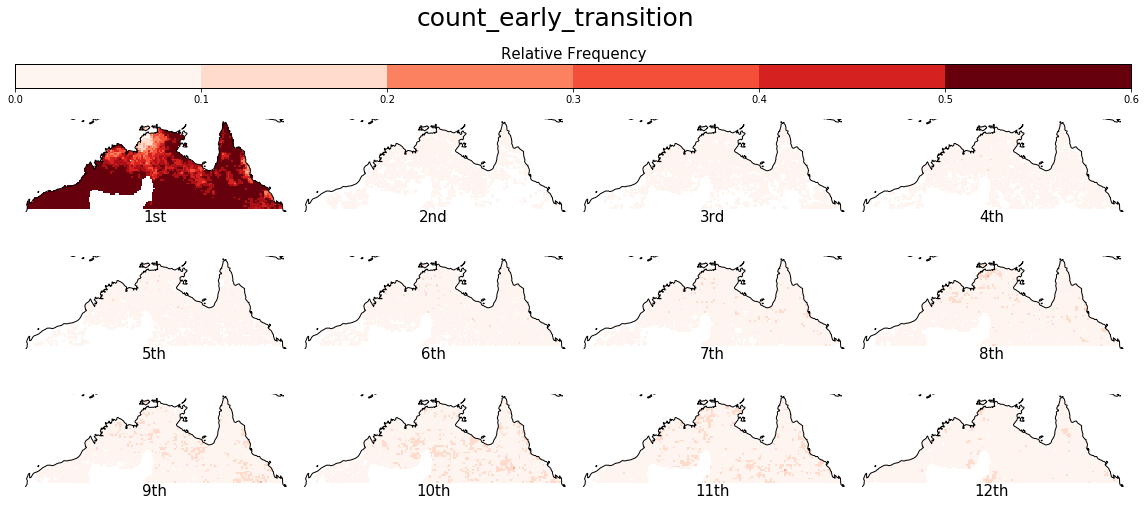

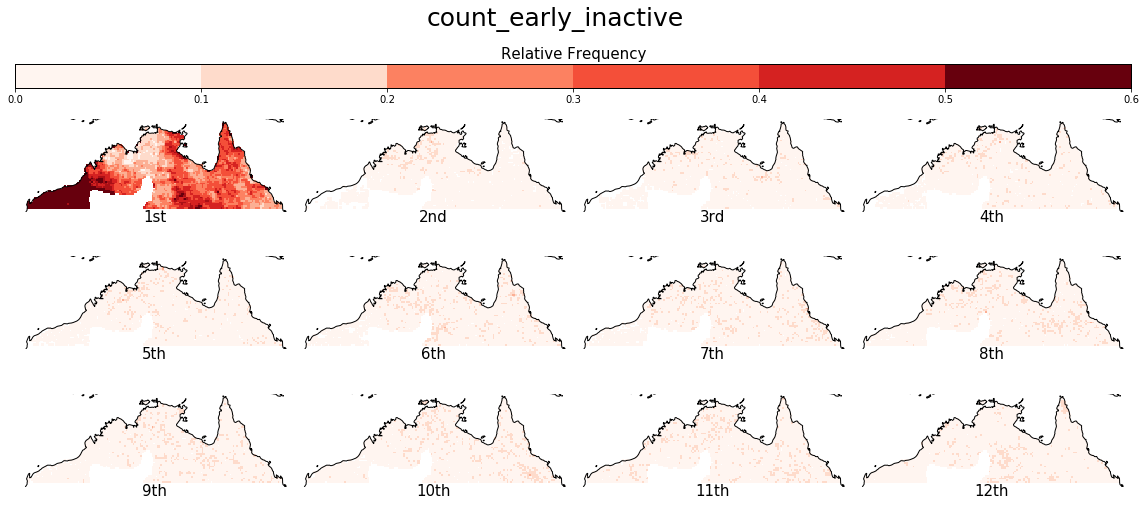

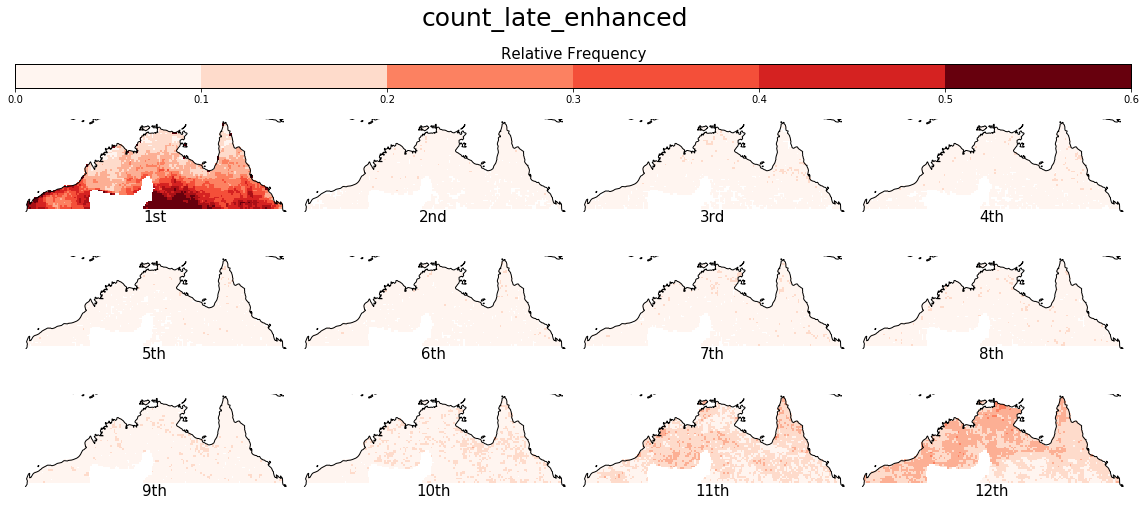

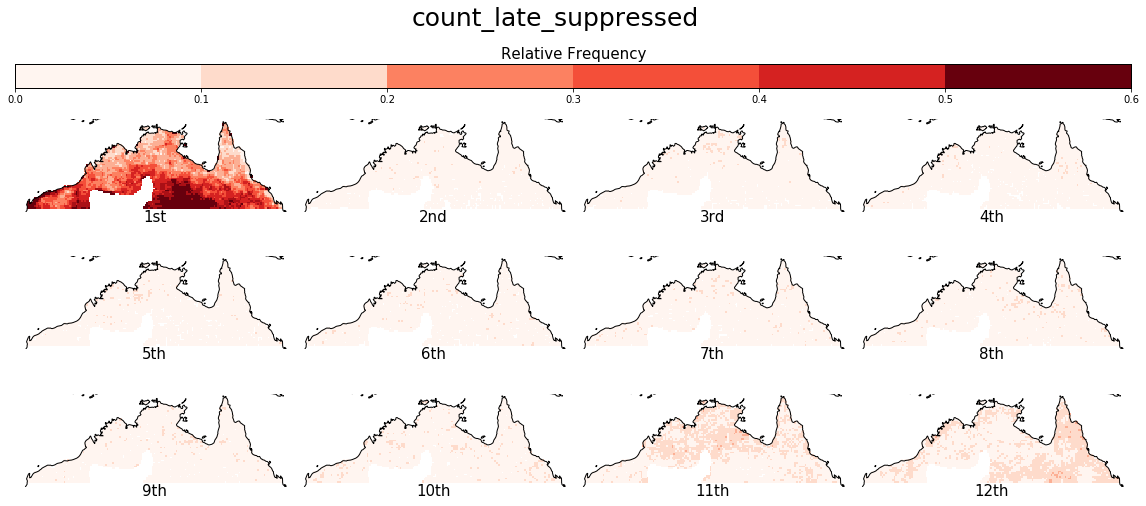

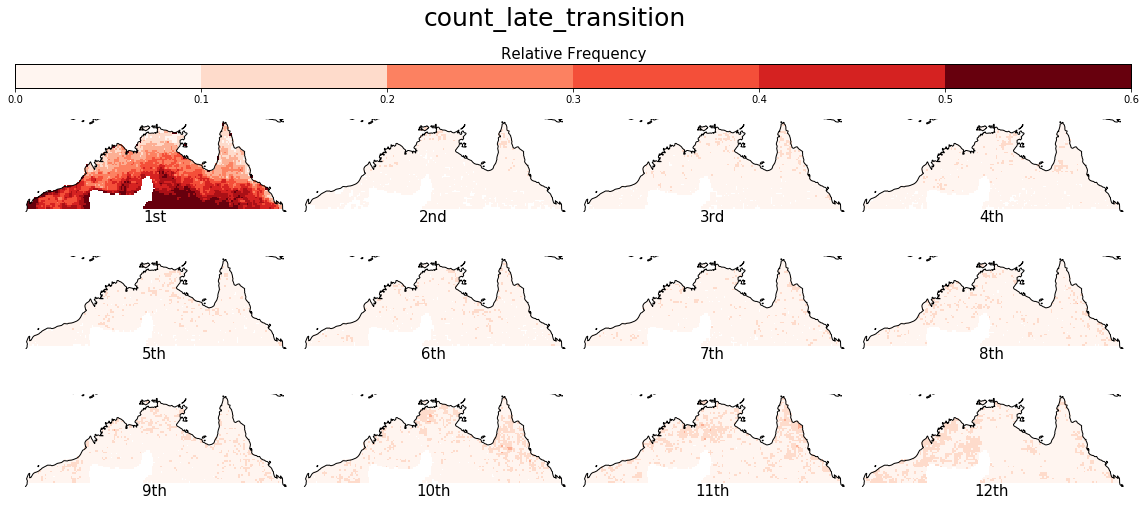

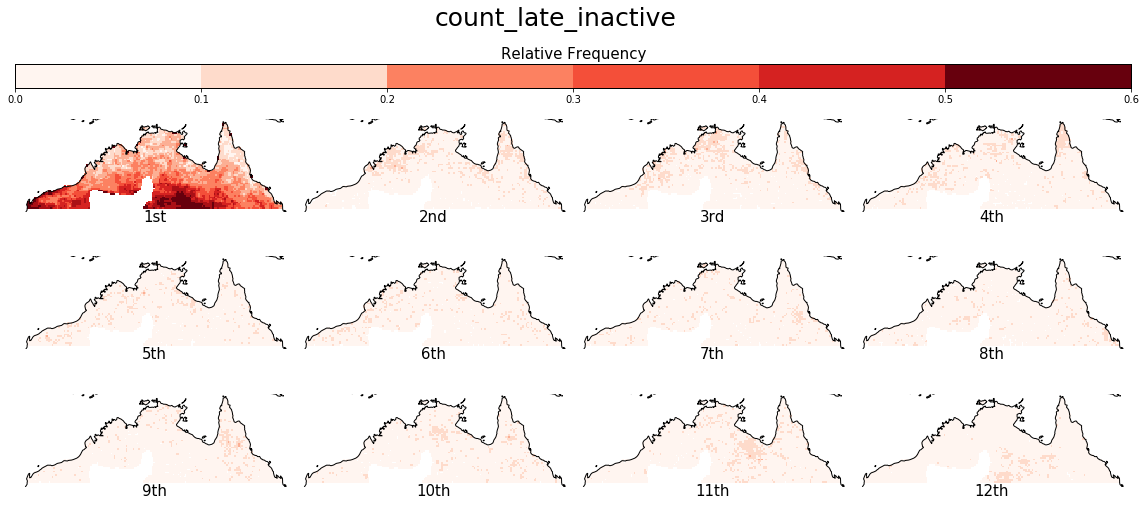

In [50]:
rhpm = reload(rhpm)


for month in rel_freq.month.values:
    for phase in rel_freq.phase.values:

        save_name = f"count_{month}_{phase}"
        single_phase = rel_freq.sel(phase = phase, month = month)
        rhpm.rank_maps(single_phase, save_name = save_name, savedir = savedir_count_1)

## Argmax

In [51]:
savedir_count_2 = savedir + 'argmax/'

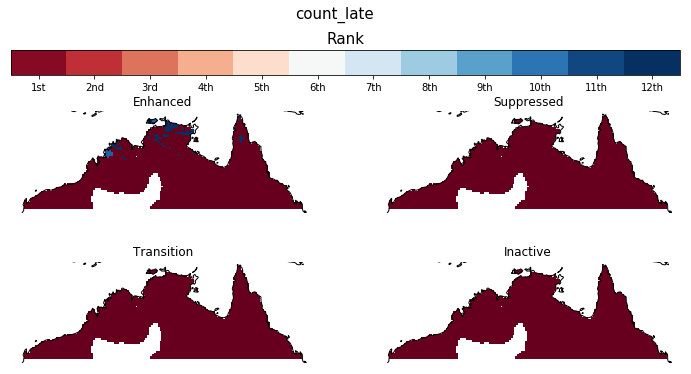

In [52]:
rhpm = reload(rhpm)
month = 'late'
savetitle = f'count_{month}'
rhpm.argmax_map_plot(argmax.sel(month = month), savetitle = savetitle)#, savedir = savedir_count_2)

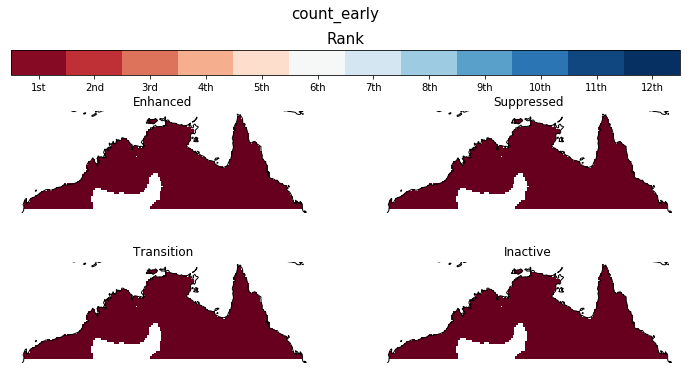

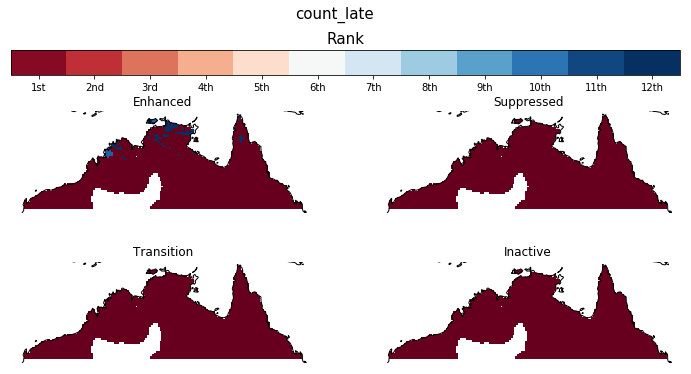

In [53]:
rhpm = reload(rhpm)

for month in argmax.month.values:
    savetitle = f'count_{month}'
    rhpm.argmax_map_plot(argmax.sel(month = month), savetitle = savetitle, savedir = savedir_count_2)

## Total Bar

# Intensity

## Calculation

In [148]:
savedir_int = 'plots_2/rank_hist/int/'

In [139]:
def group_resample_mean(group):
        return group.groupby('time.year').mean()


In [141]:
function = group_resample_mean
rank_int = rank_create(awap_split, access_split, function)

In [142]:
rank_int

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * month    (month) int64 1 2 3 10 11 12
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (month, year, phase, lat, lon) int64 1 6 6 6 6 6 6 ... 1 1 1 1 1 1

In [145]:
rel_freq_int = ranks_to_rel_freq(rank_int)

In [146]:
rel_freq_int 

<xarray.Dataset>
Dimensions:    (lat: 49, lon: 149, month: 6, phase: 4, rank_: 12)
Coordinates:
  * phase      (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * month      (month) int64 1 2 3 10 11 12
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * rank_      (rank_) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    frequency  (rank_, month, phase, lat, lon) float64 1.0 0.5652 ... 0.0 0.0

In [164]:
argmax_int = calc_argmax(rel_freq_int)

## Hist Plots

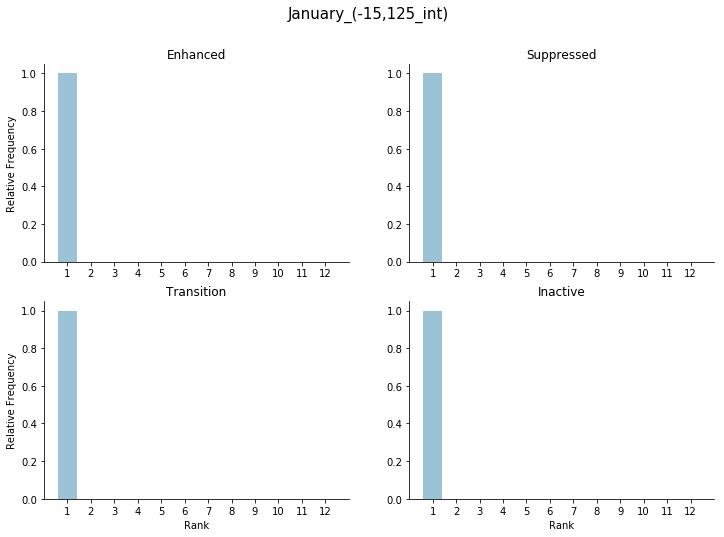

In [160]:
rhpm = reload(rhpm)
month = 1
lat = -15
lon = 125

save_name = f'{calendar.month_name[month]}_({lat},{lon}_int)'
data = rel_freq_int.sel(month = month, lat = lat, lon = lon)
rhpm.generate_phase_hist(data,  save_name = save_name, savedir = savedir_int + 'hists/')

## Maps

In [161]:
savedir_int_1 = savedir_int + 'maps/'

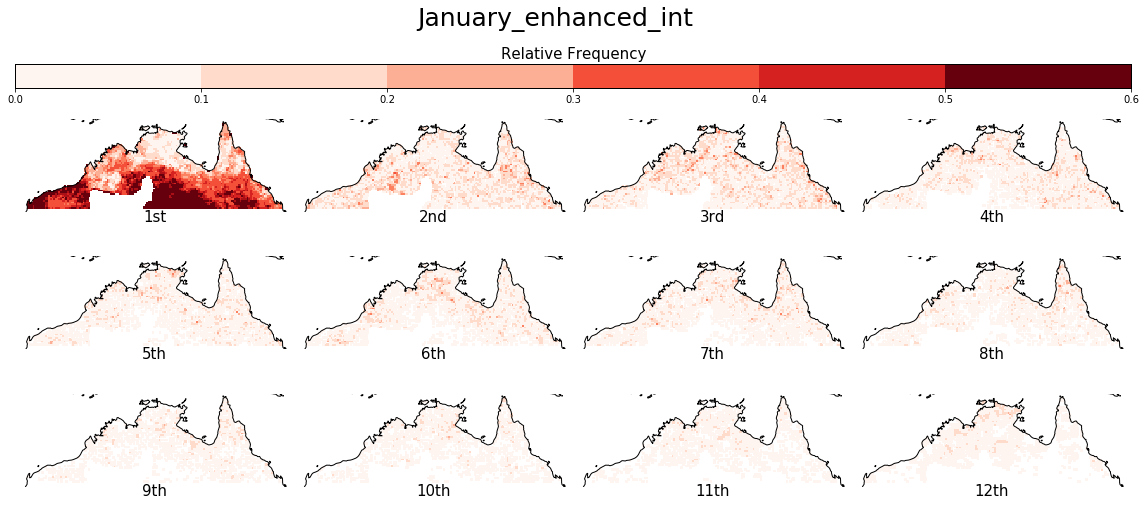

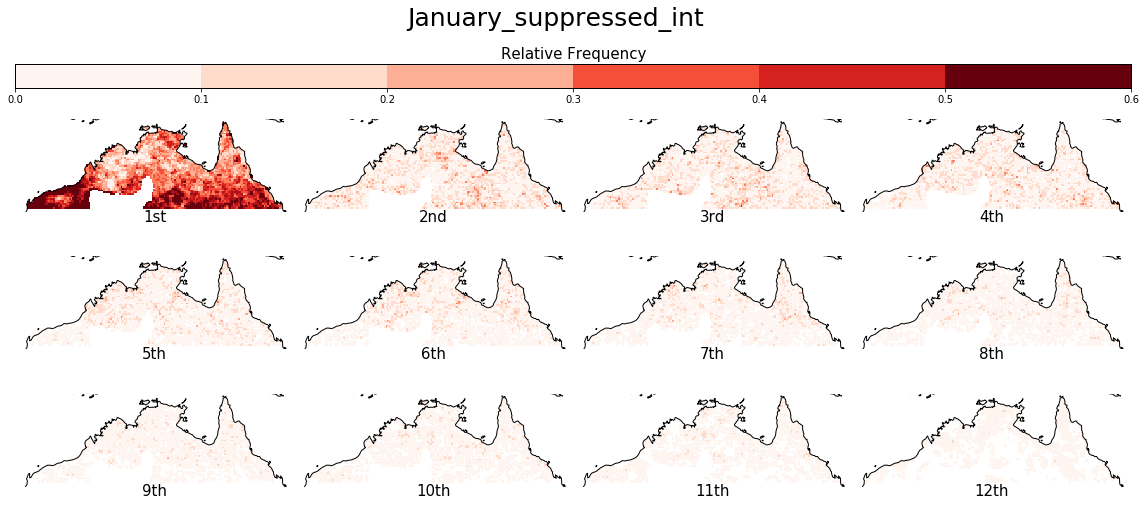

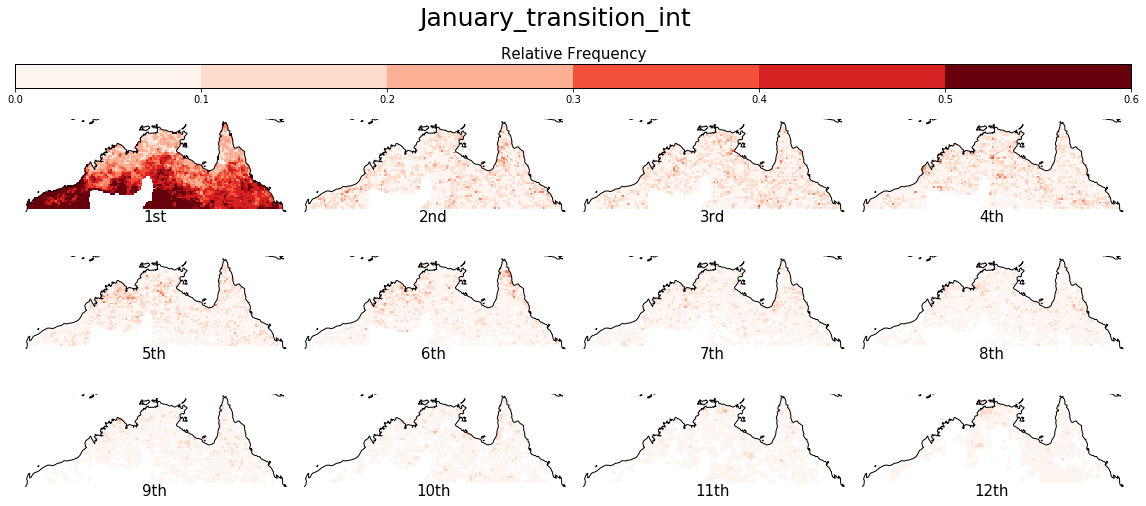

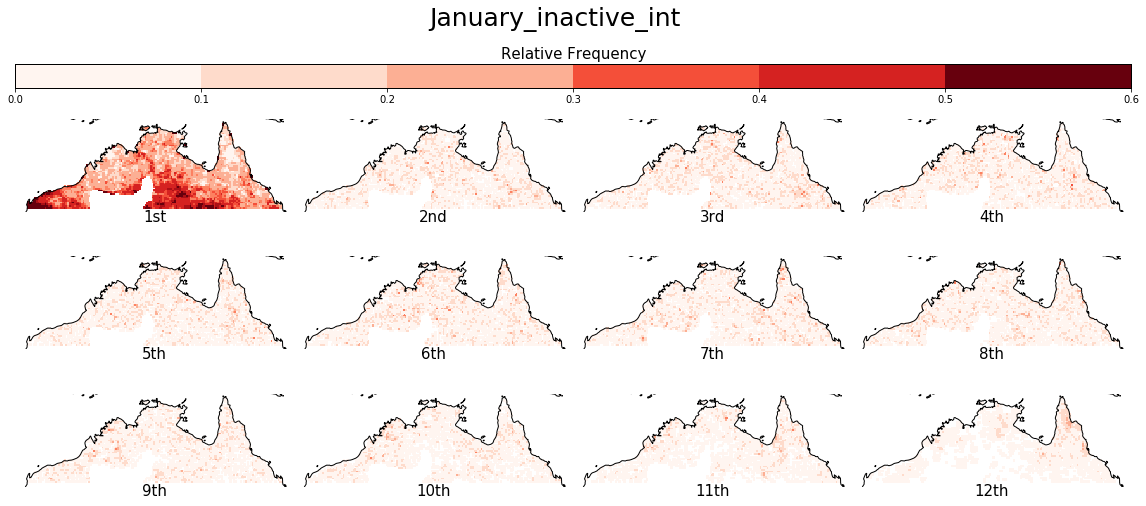

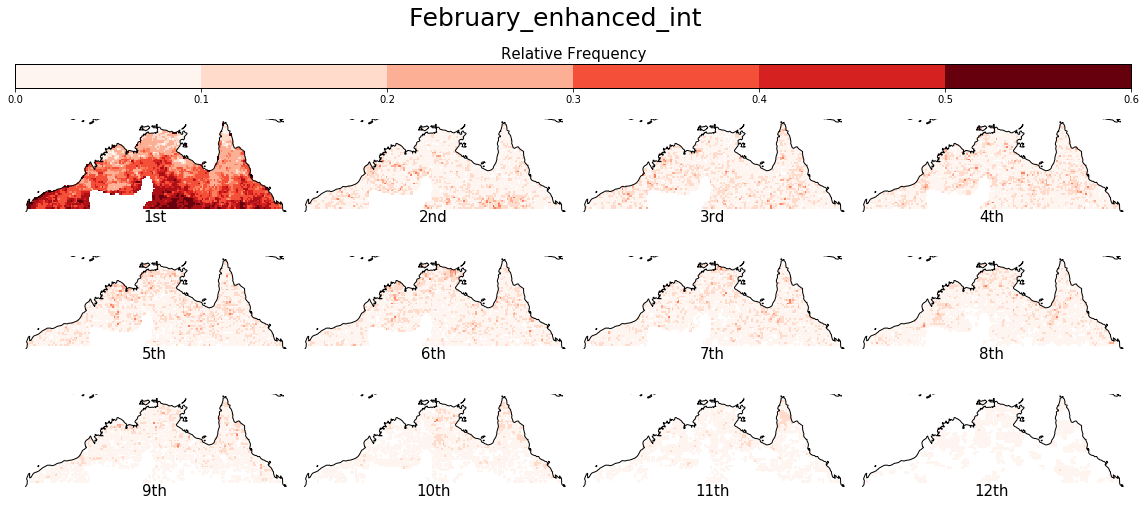

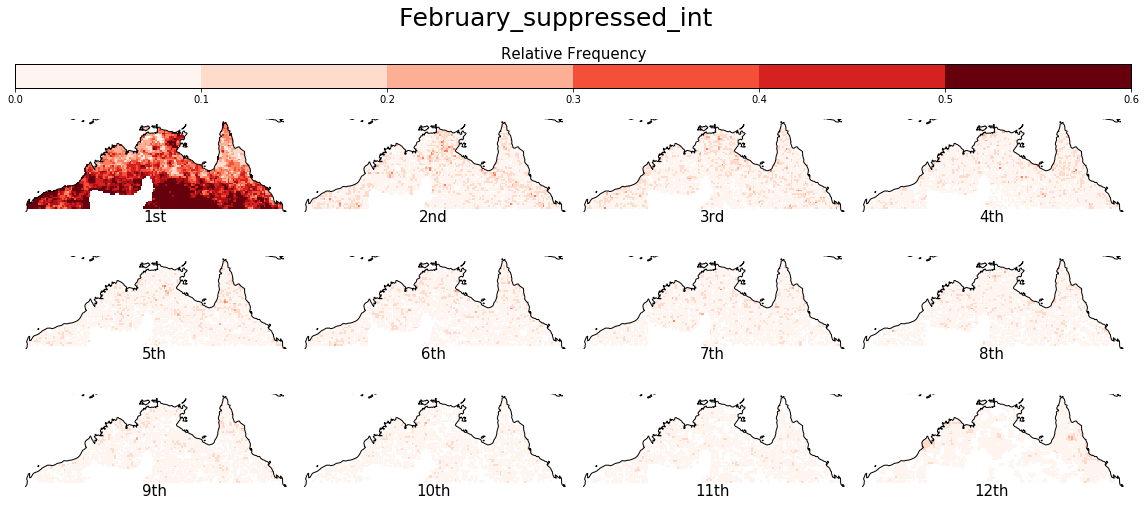

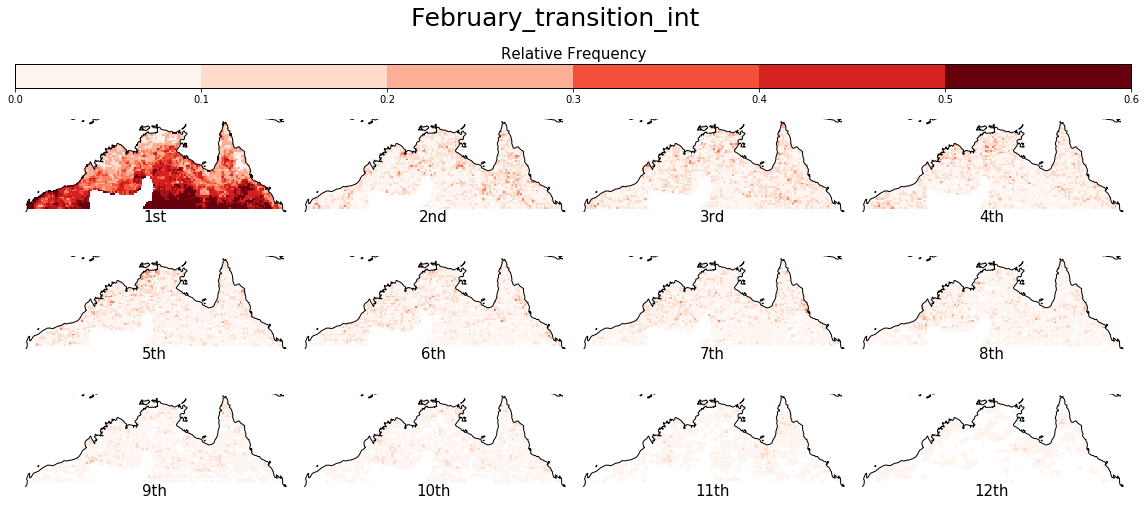

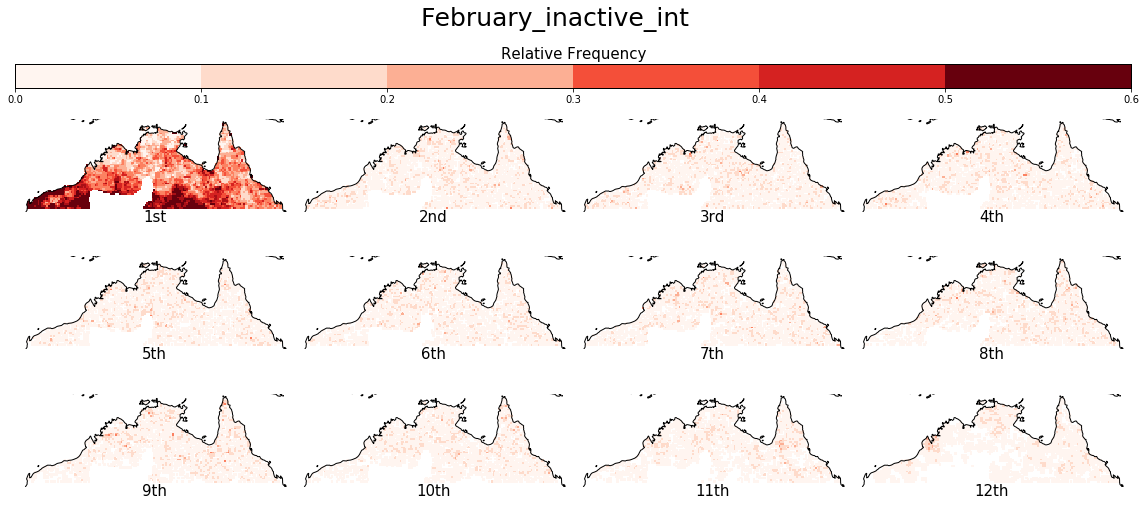

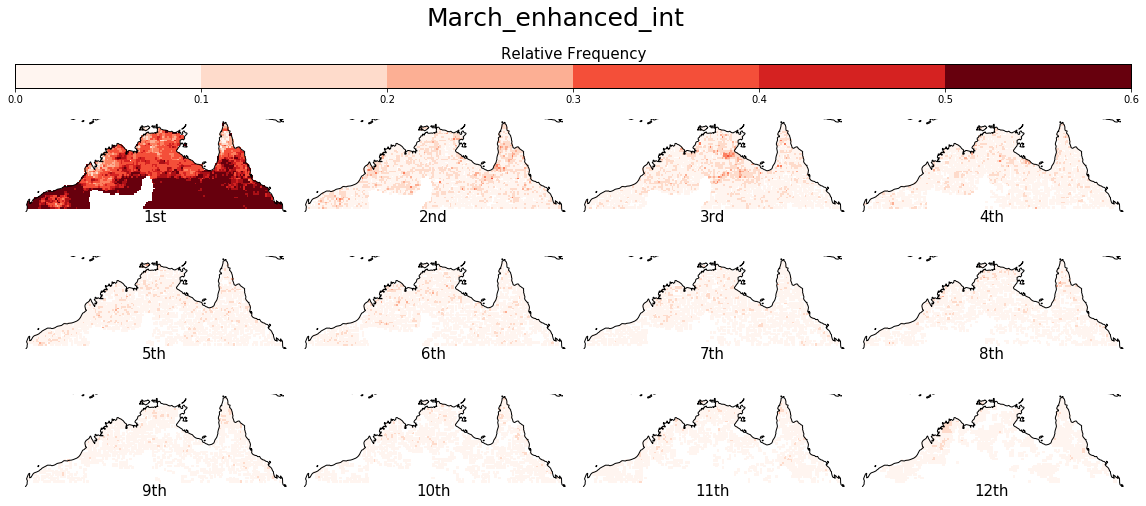

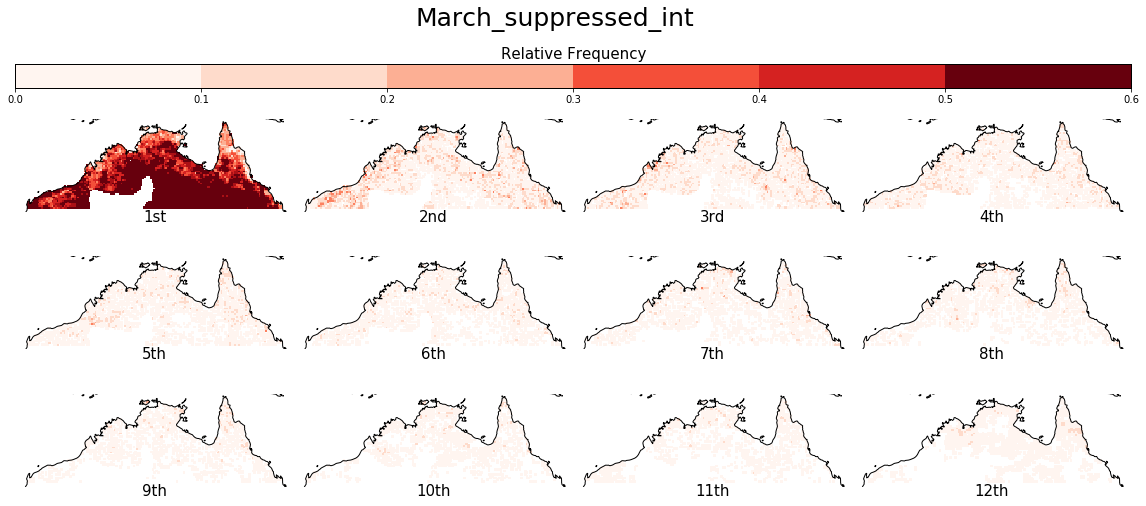

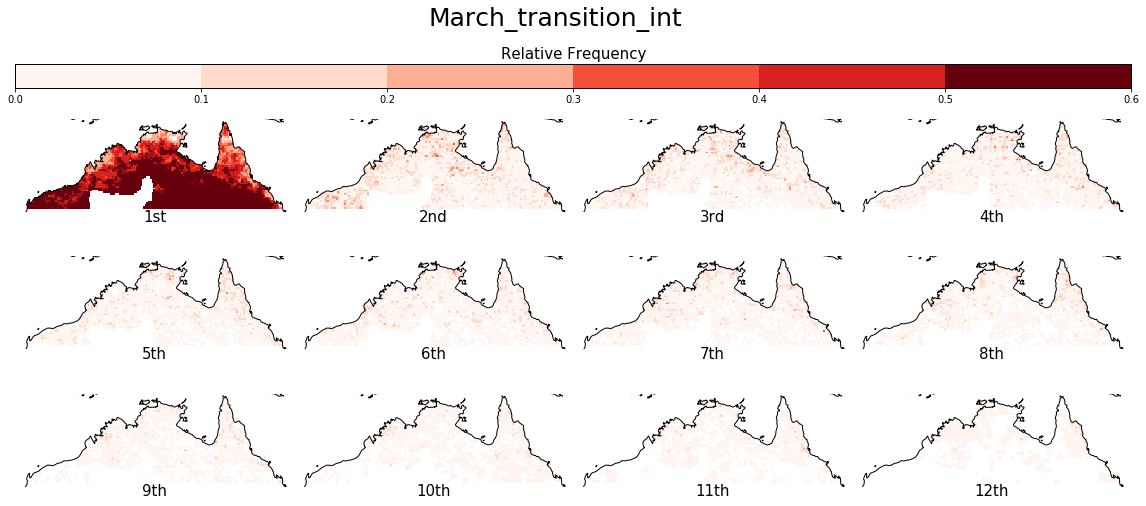

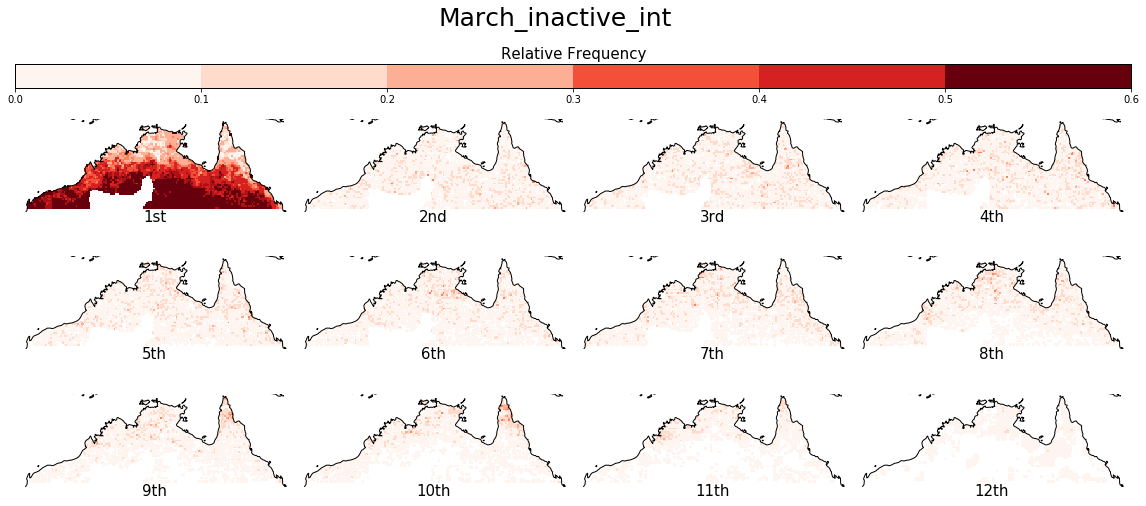

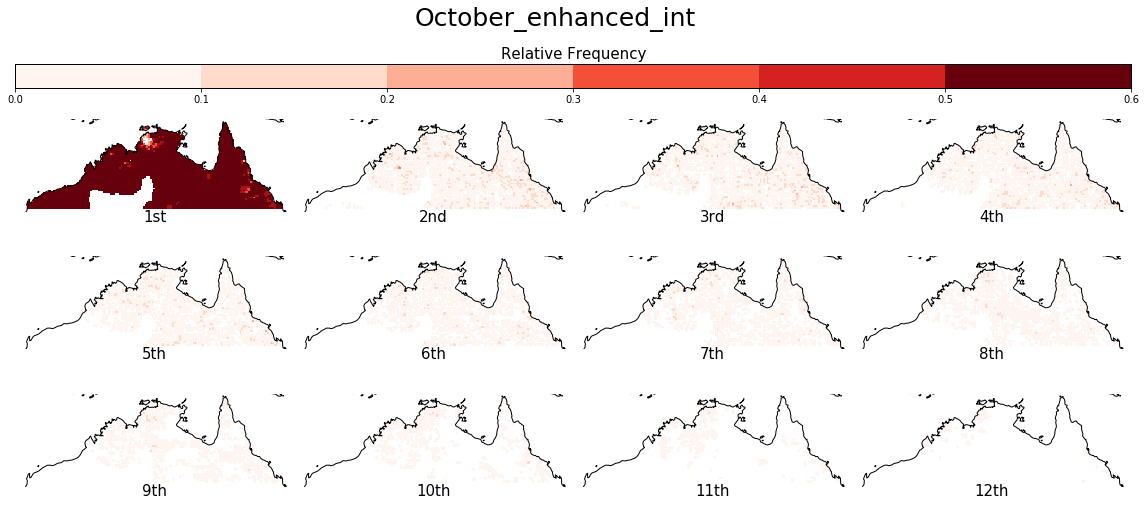

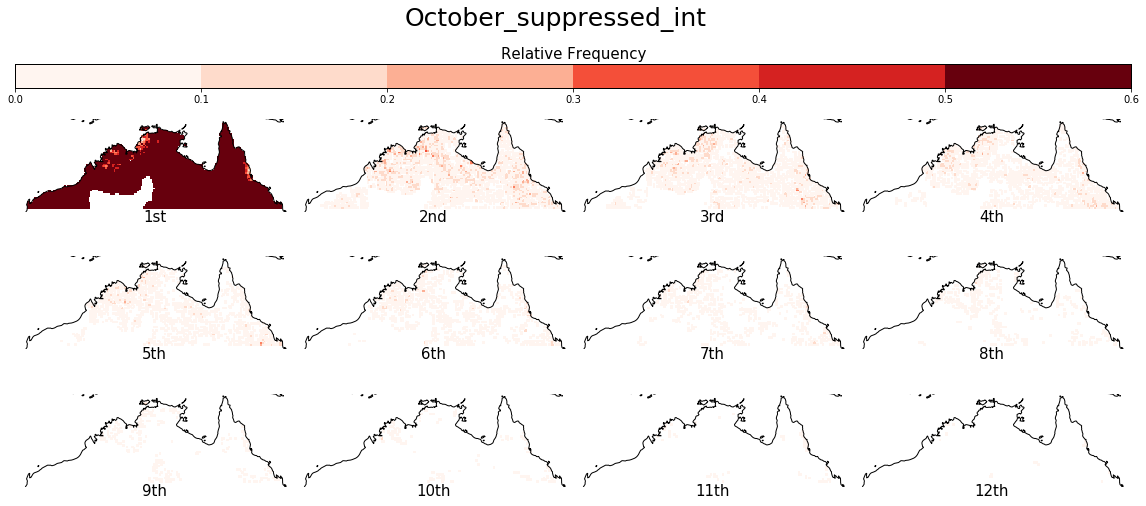

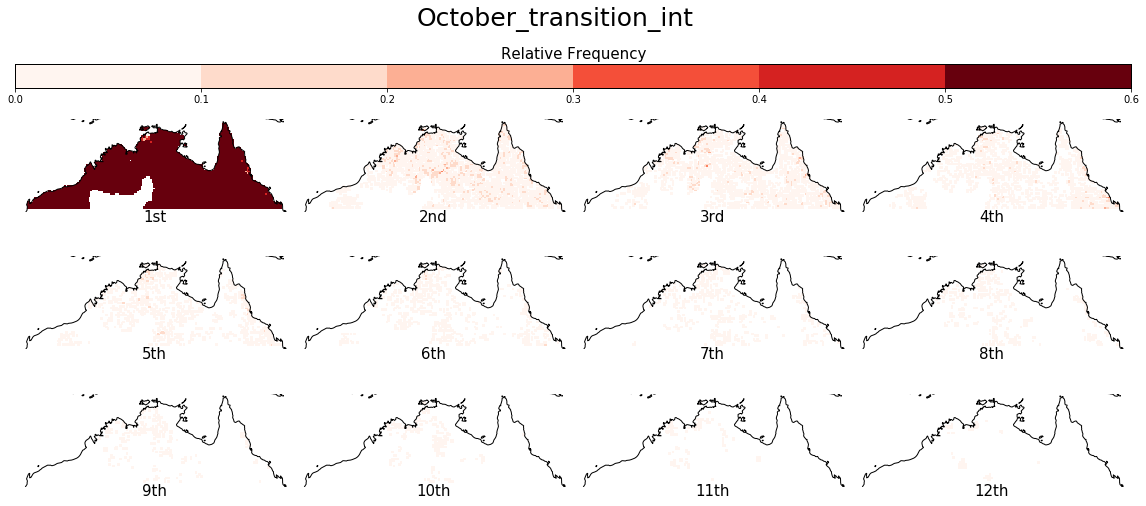

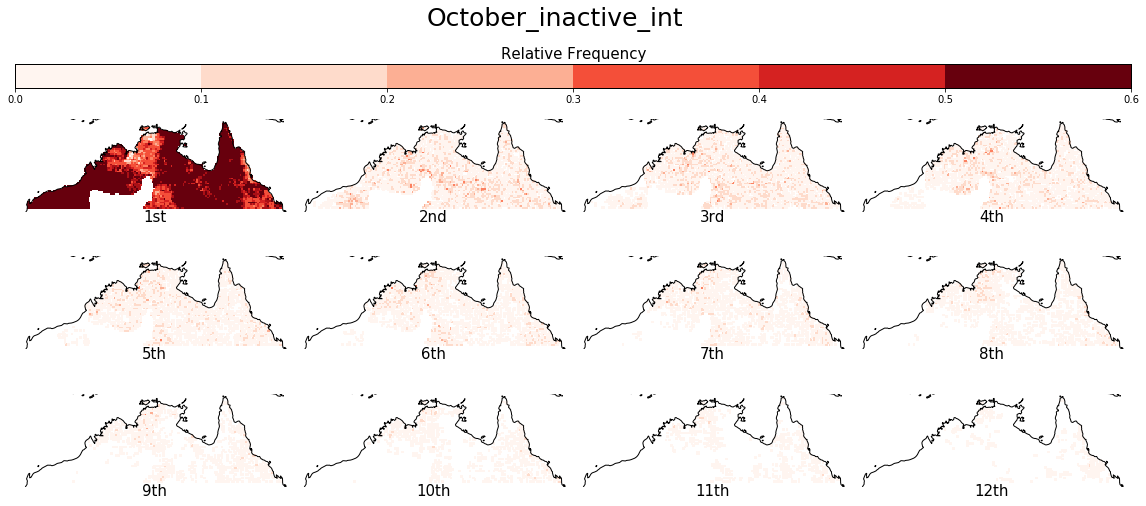

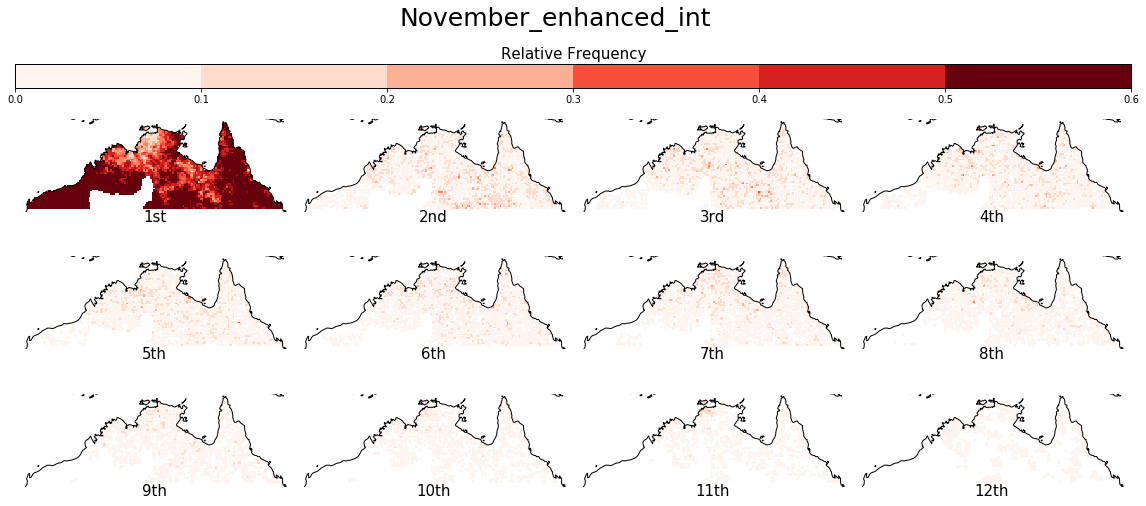

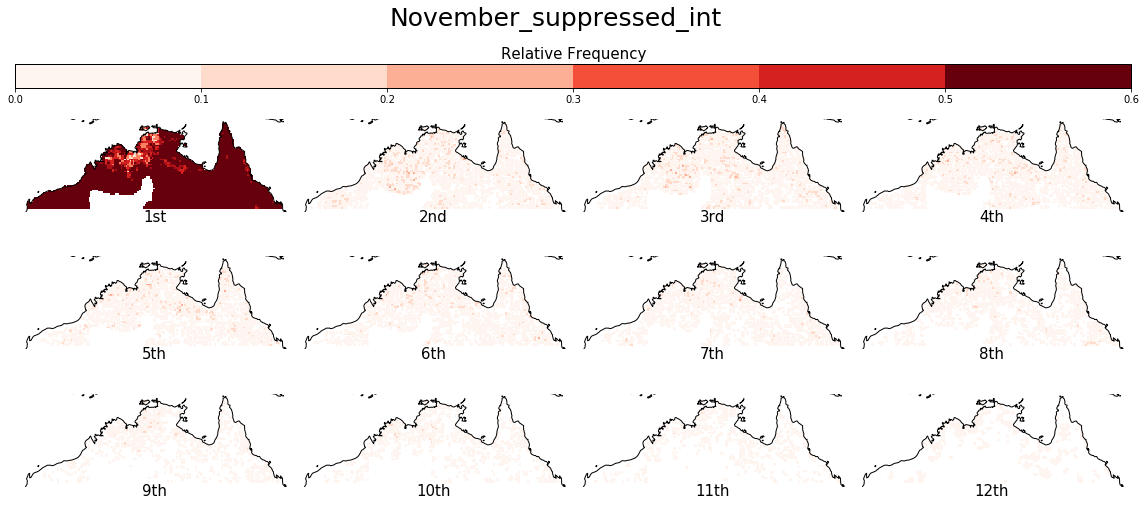

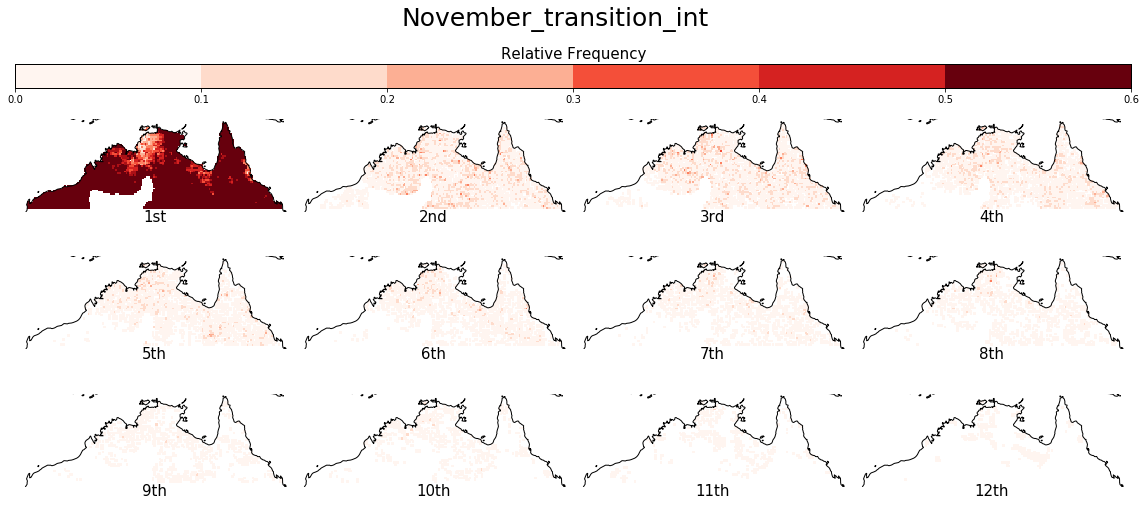

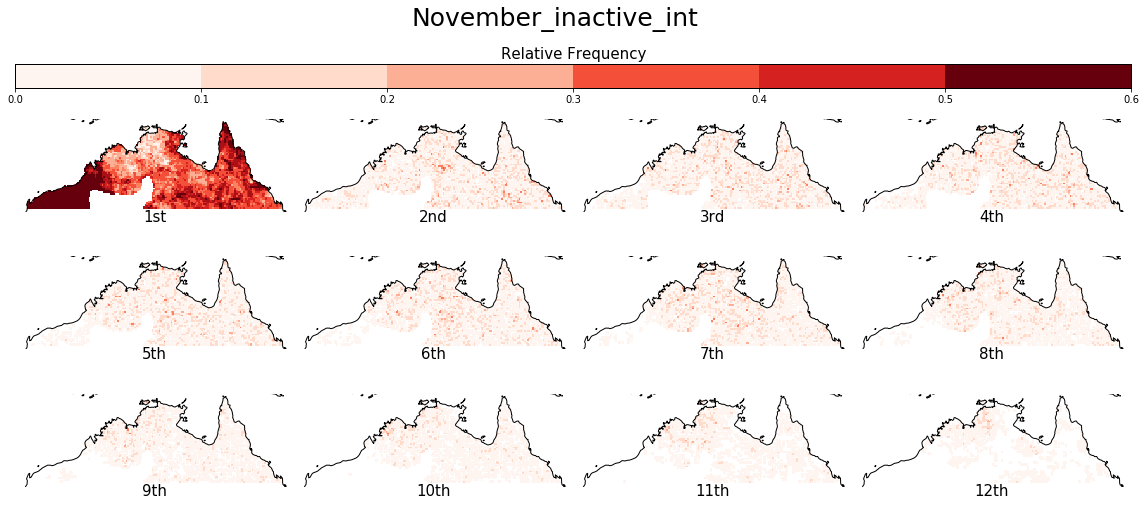

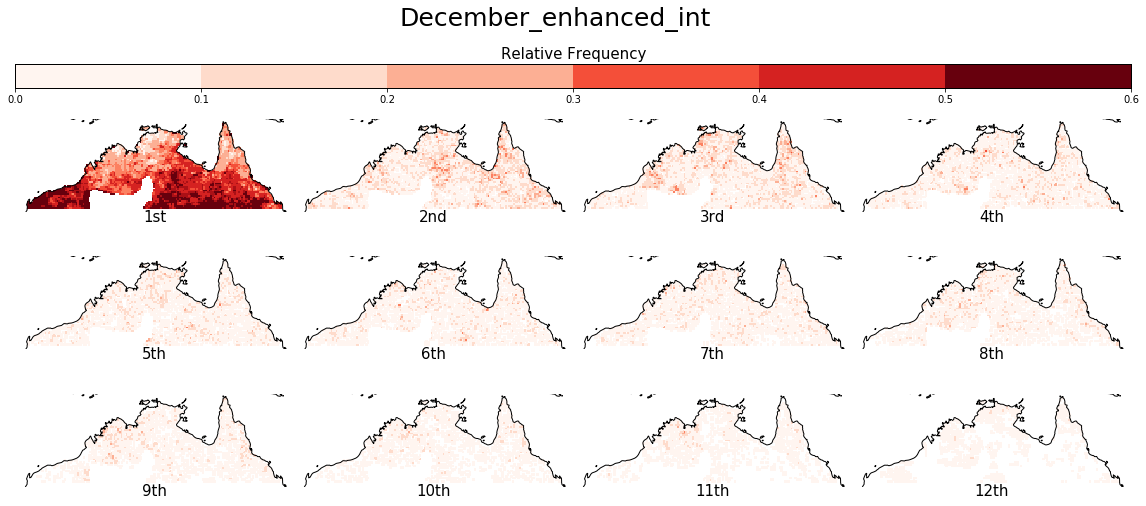

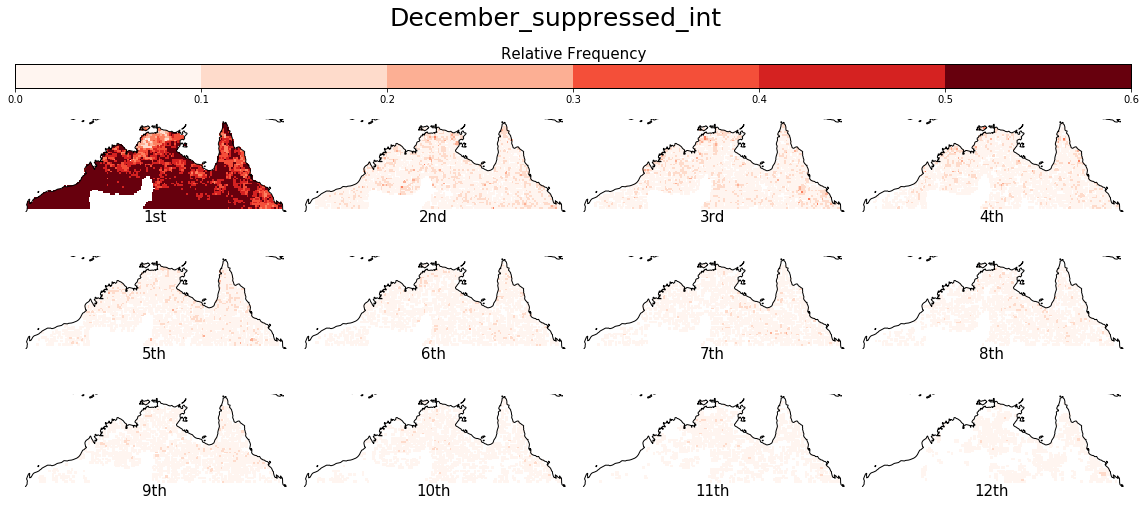

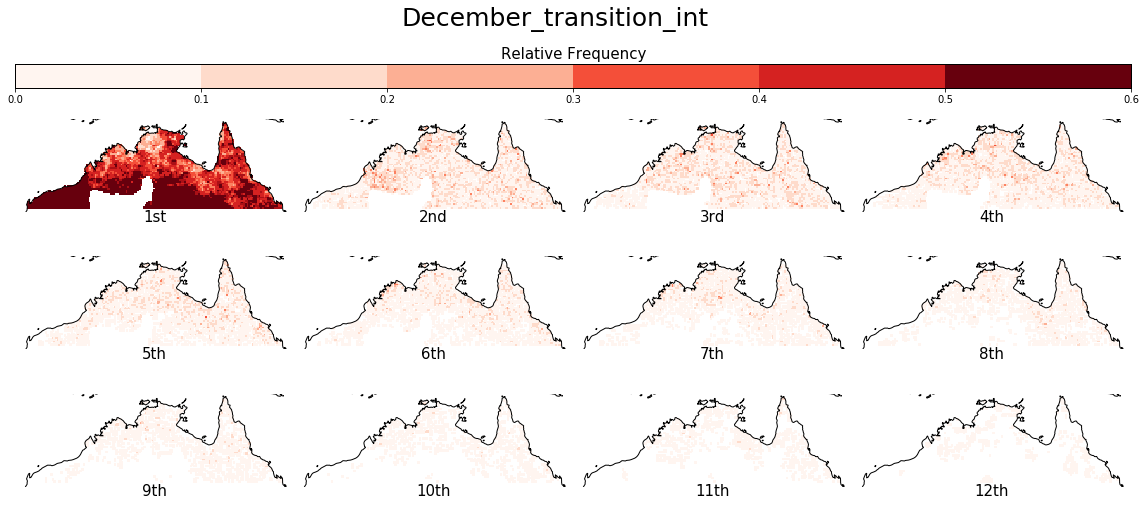

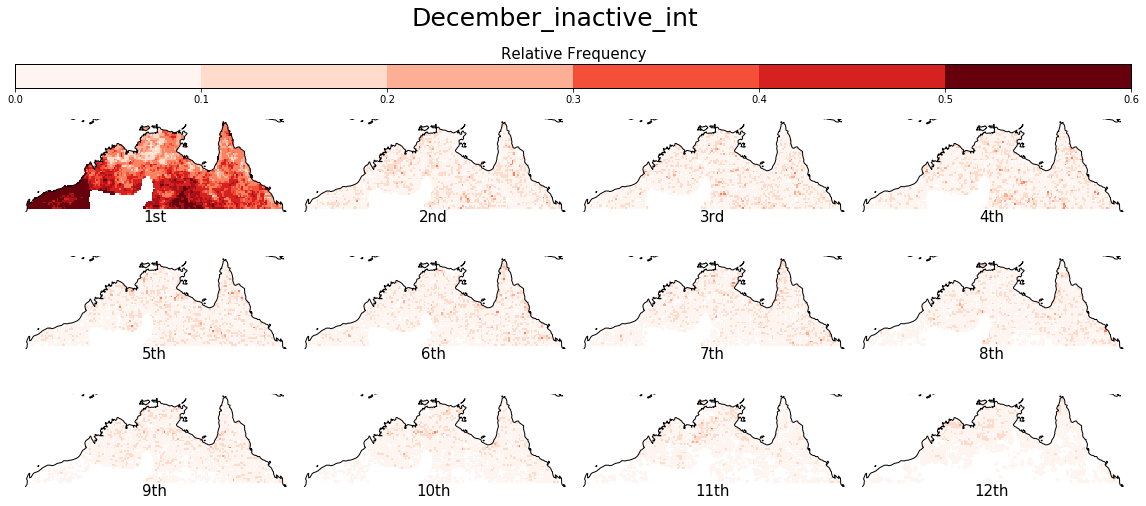

In [162]:
rhpm = reload(rhpm)


for month in rel_freq_int.month.values:
    for phase in rel_freq_int.phase.values:

        save_name = f"{calendar.month_name[month]}_{phase}_int"
        single_phase = rel_freq_int.sel(phase = phase, month = month)
        rhpm.rank_maps(single_phase, save_name = save_name, savedir = savedir_int_1)

## Argmax

In [166]:
savedir_int_2 = savedir_int + 'argmax/'

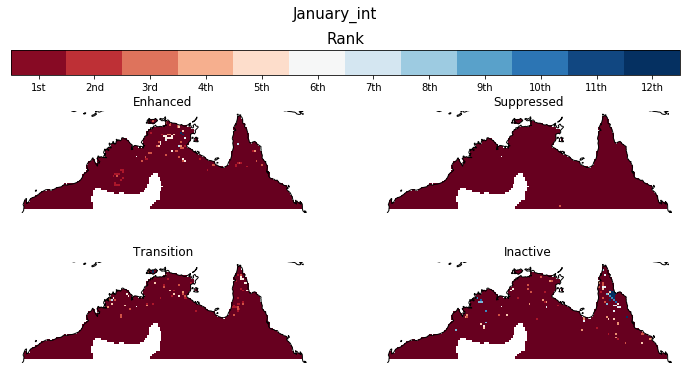

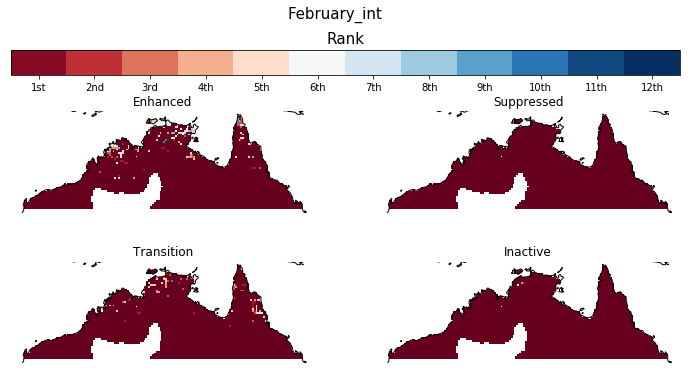

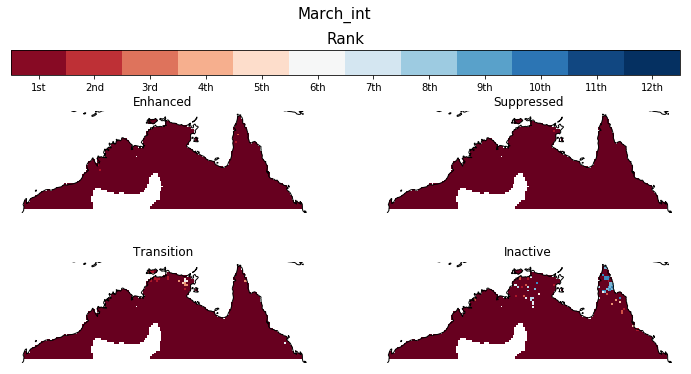

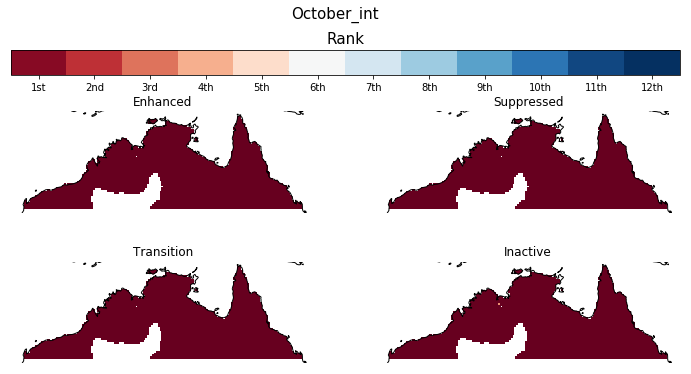

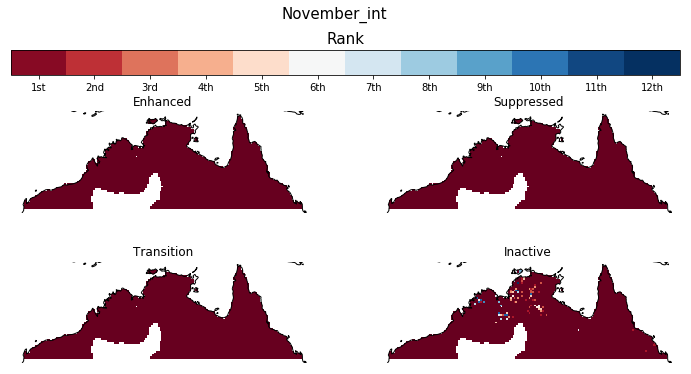

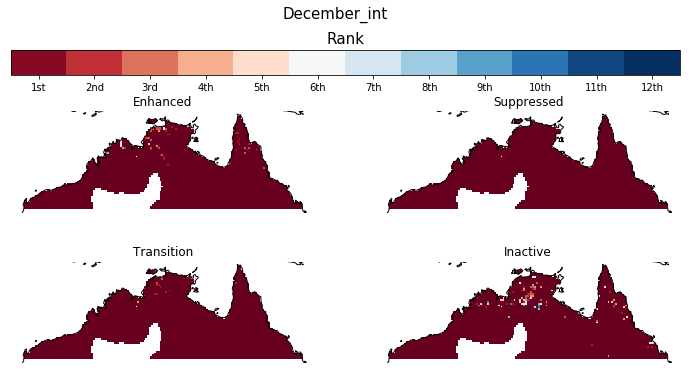

In [167]:
rhpm = reload(rhpm)

for month in argmax.month.values:
    savetitle = f'{calendar.month_name[month]}_int'
    rhpm.argmax_map_plot(argmax_int.sel(month = month), savetitle = savetitle, savedir = savedir_int_2)

# Sum

## Calculation

In [178]:
savedir_sum = 'plots_2/rank_hist/sum/'

In [168]:
def group_resample_sum(group):
        return group.groupby('time.year').sum()


In [169]:
function = group_resample_sum
rank_sum = rank_create(awap_split, access_split, function)

In [170]:
rank_sum

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * month    (month) int64 1 2 3 10 11 12
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (month, year, phase, lat, lon) int64 1 12 12 12 12 12 ... 1 1 1 1 1

In [175]:
rel_freq_sum = ranks_to_rel_freq(rank_sum)

In [176]:
rel_freq_sum

<xarray.Dataset>
Dimensions:    (lat: 49, lon: 149, month: 6, phase: 4, rank_: 12)
Coordinates:
  * phase      (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lat        (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * month      (month) int64 1 2 3 10 11 12
  * lon        (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * rank_      (rank_) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    frequency  (rank_, month, phase, lat, lon) float64 1.0 0.5217 ... 0.0 0.0

In [177]:
argmax_sum = calc_argmax(rel_freq_sum)

## Hist Plots

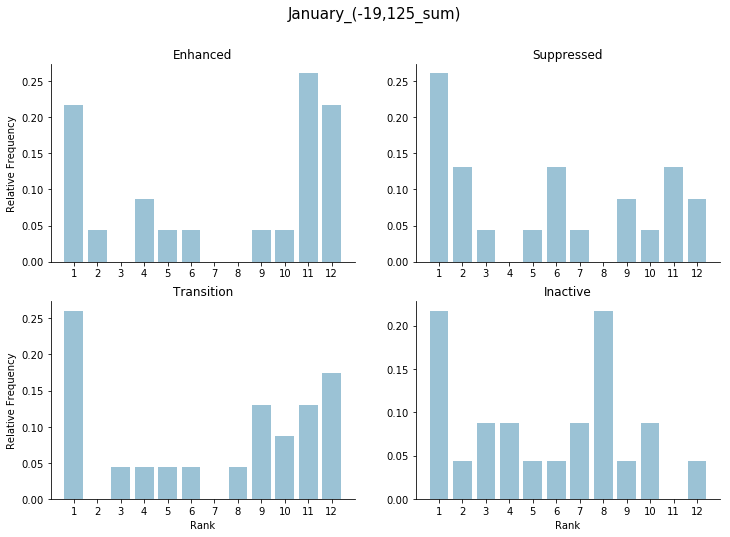

In [186]:
rhpm = reload(rhpm)
month = 1
lat = -19
lon = 125

save_name = f'{calendar.month_name[month]}_({lat},{lon}_sum)'
data = rel_freq_sum.sel(month = month, lat = lat, lon = lon)
rhpm.generate_phase_hist(data,  save_name = save_name, savedir = savedir_sum + 'hists/')

## Maps

In [187]:
savedir_sum_1 = savedir_sum + 'maps/'

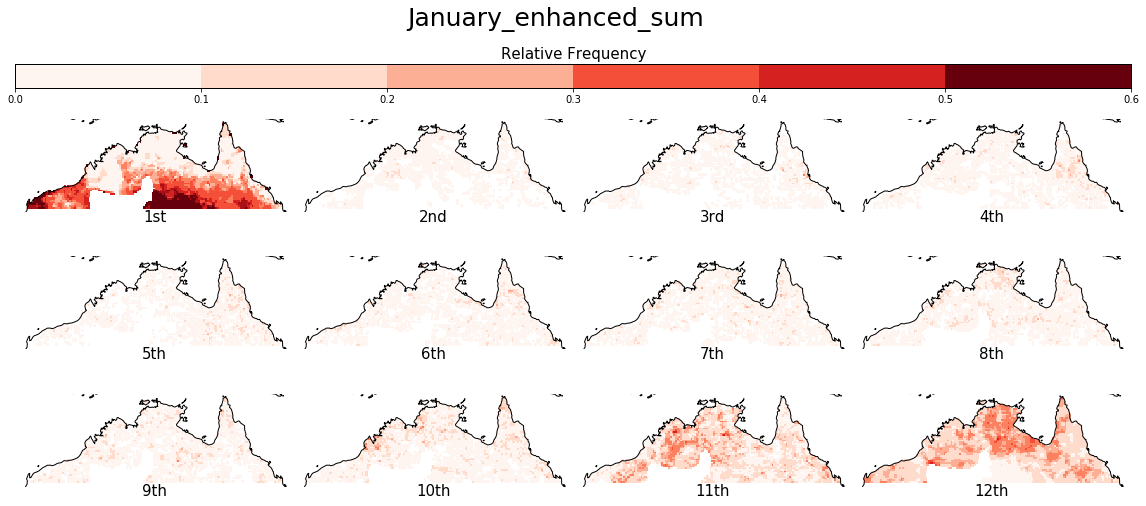

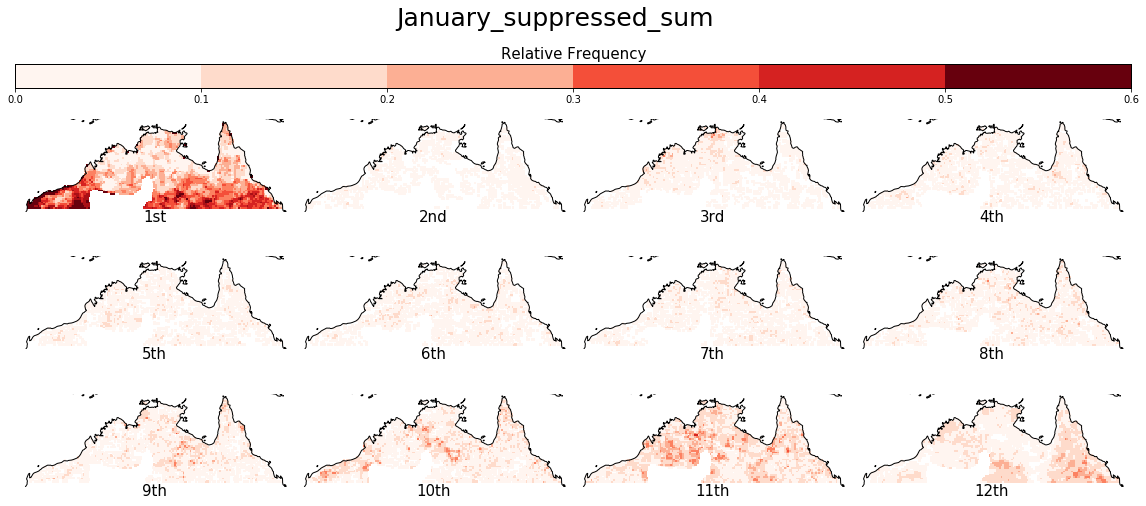

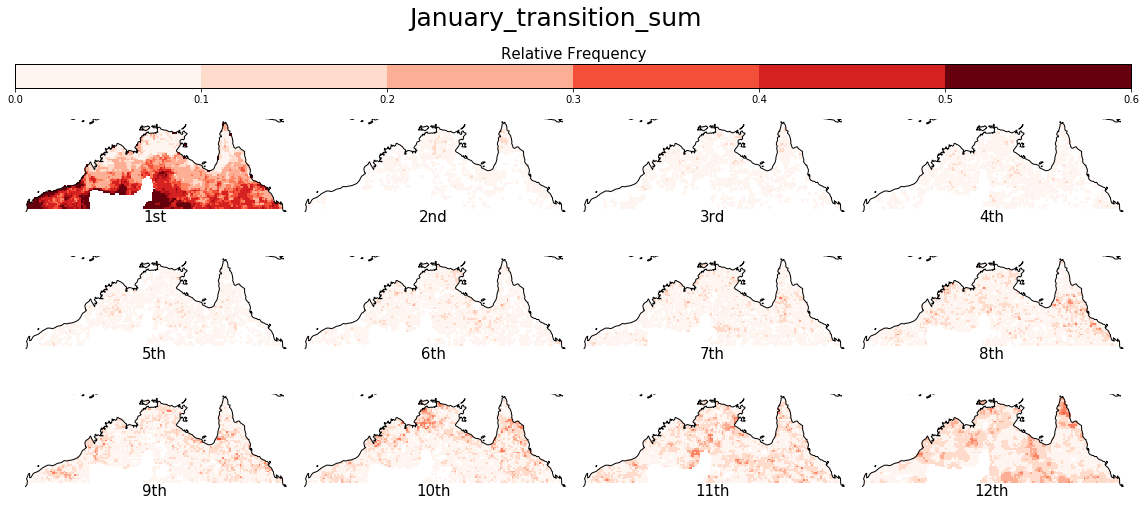

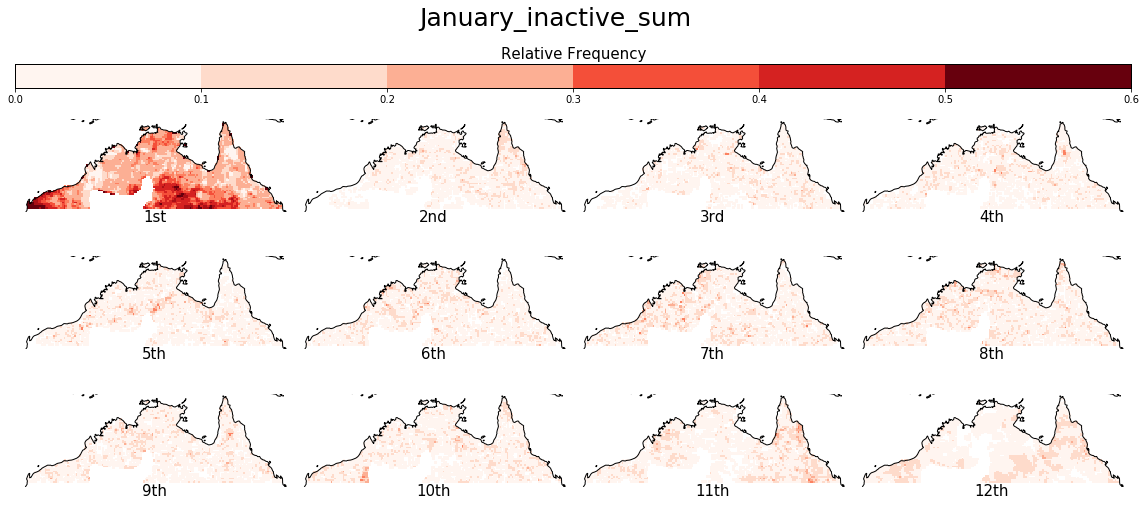

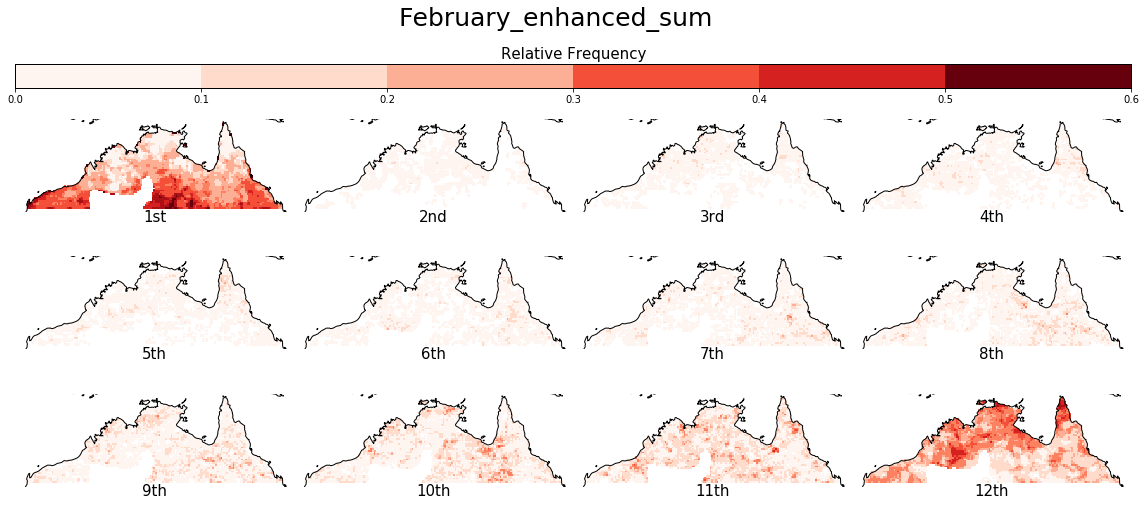

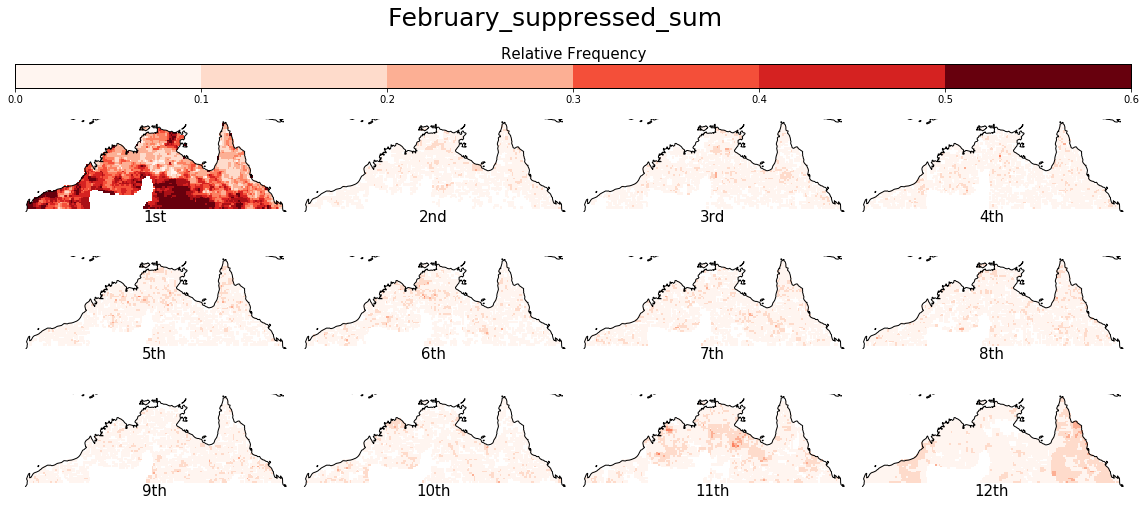

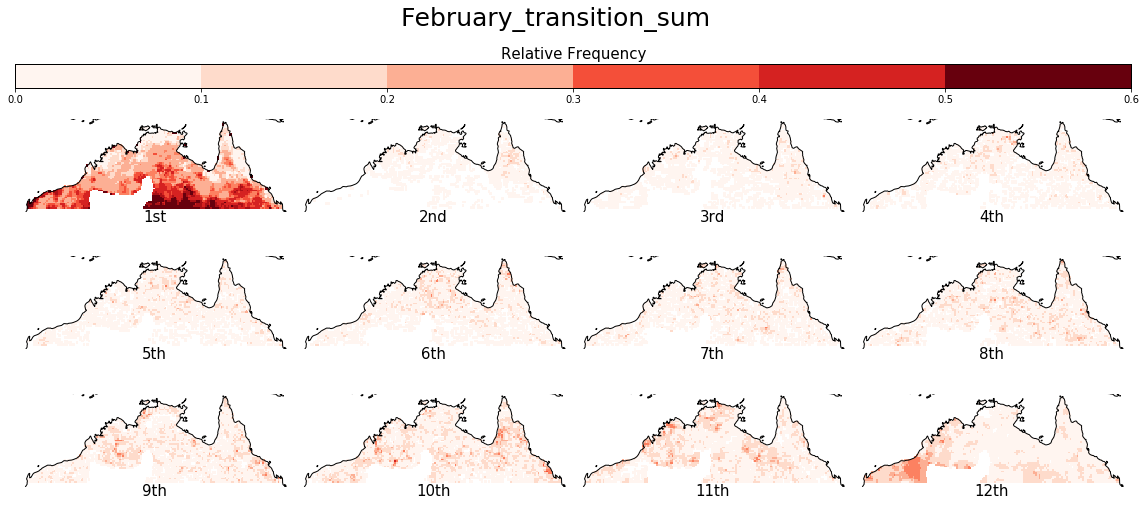

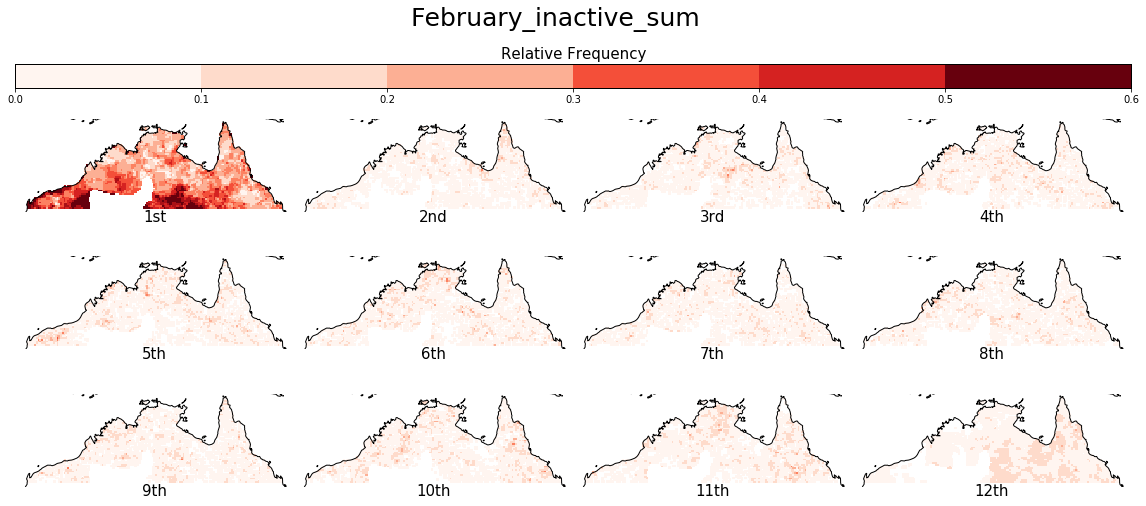

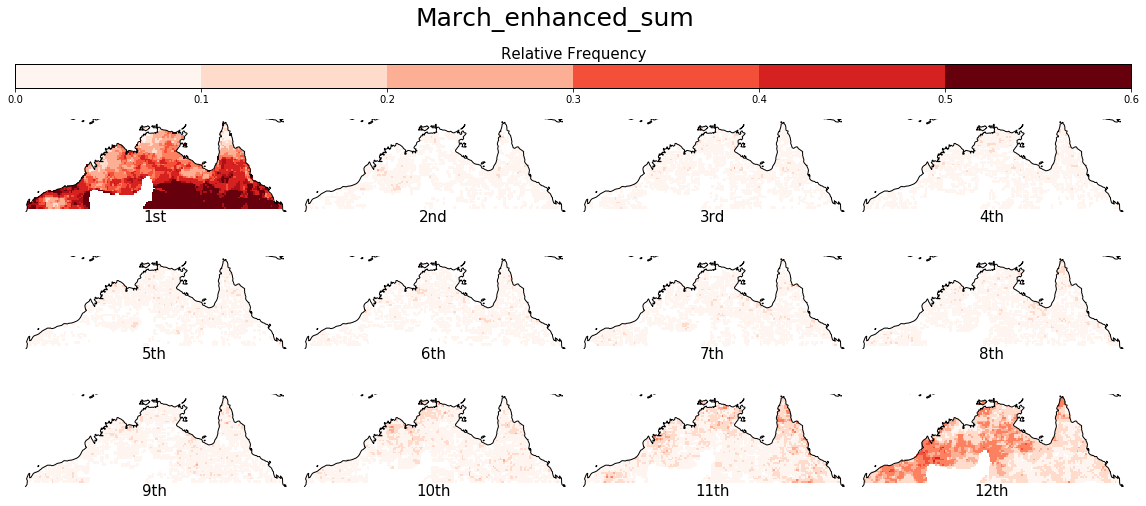

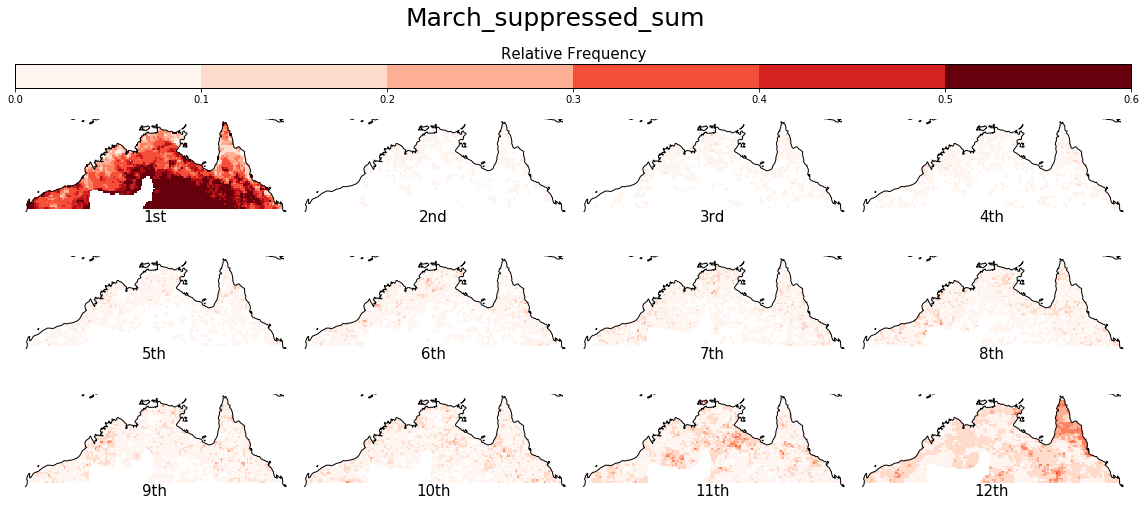

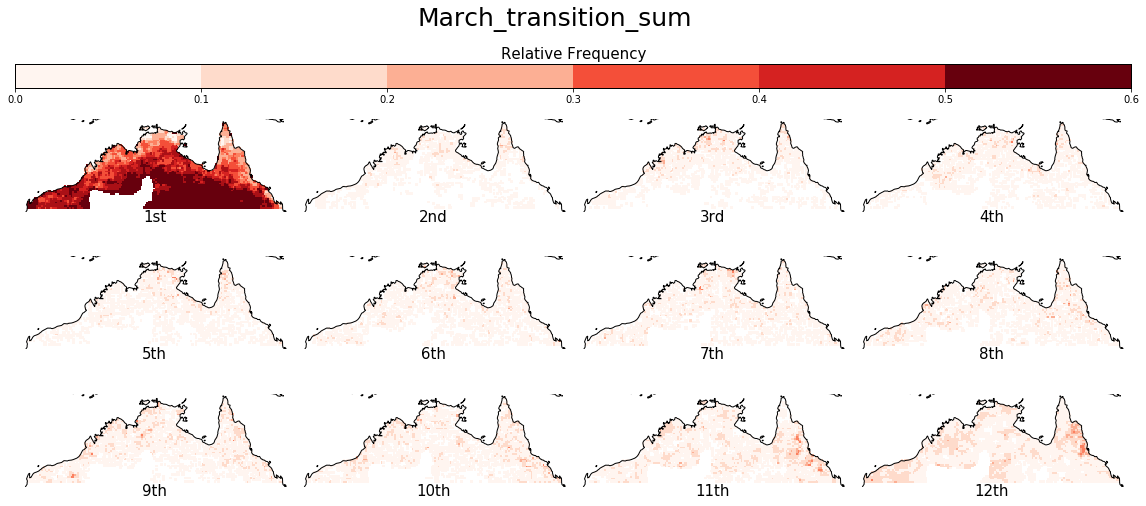

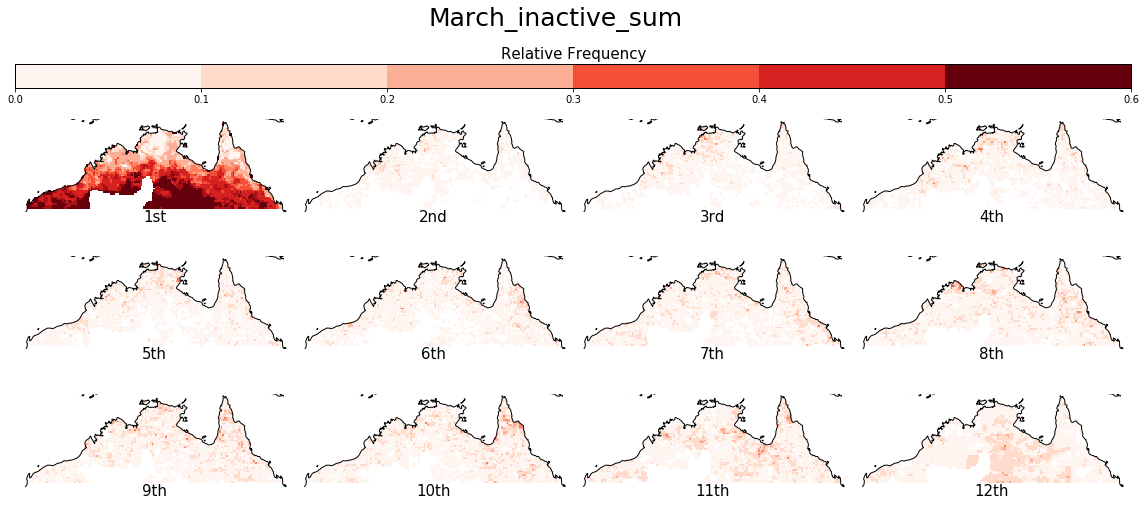

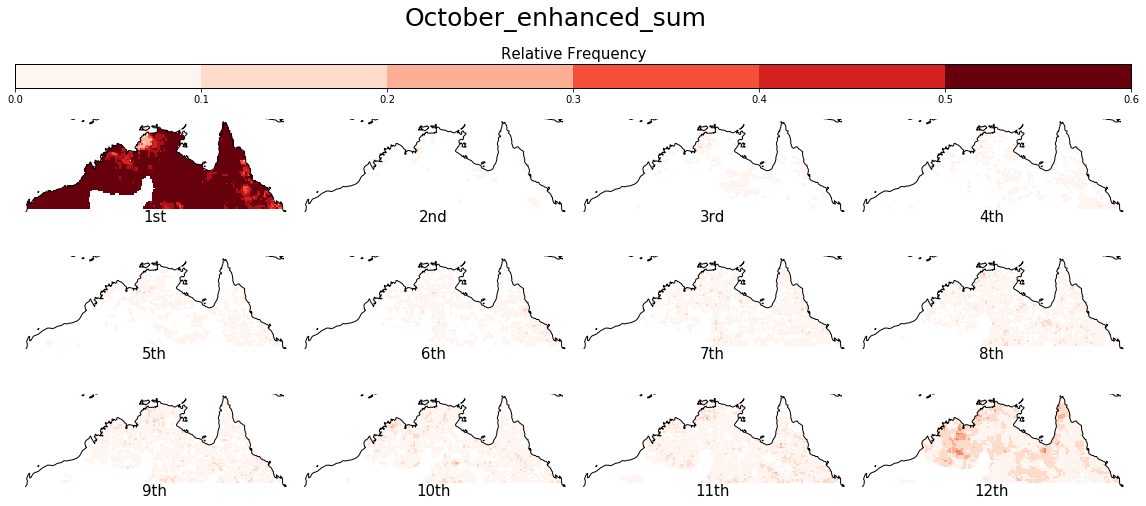

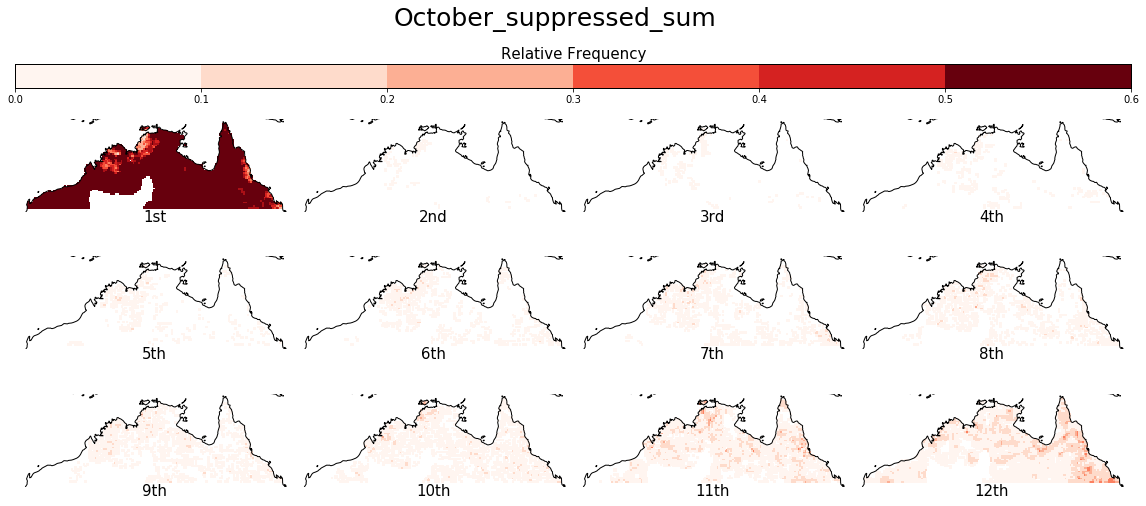

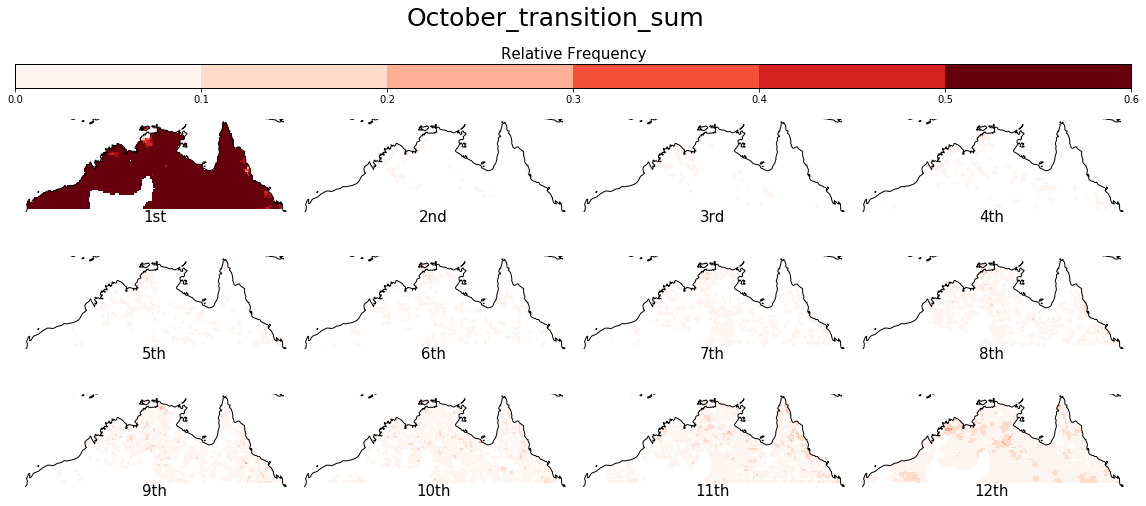

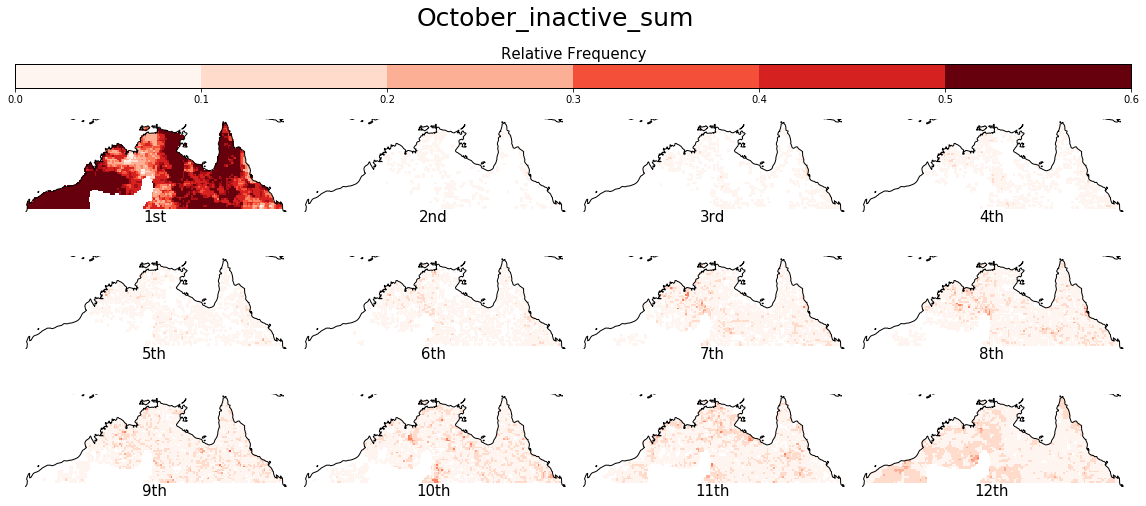

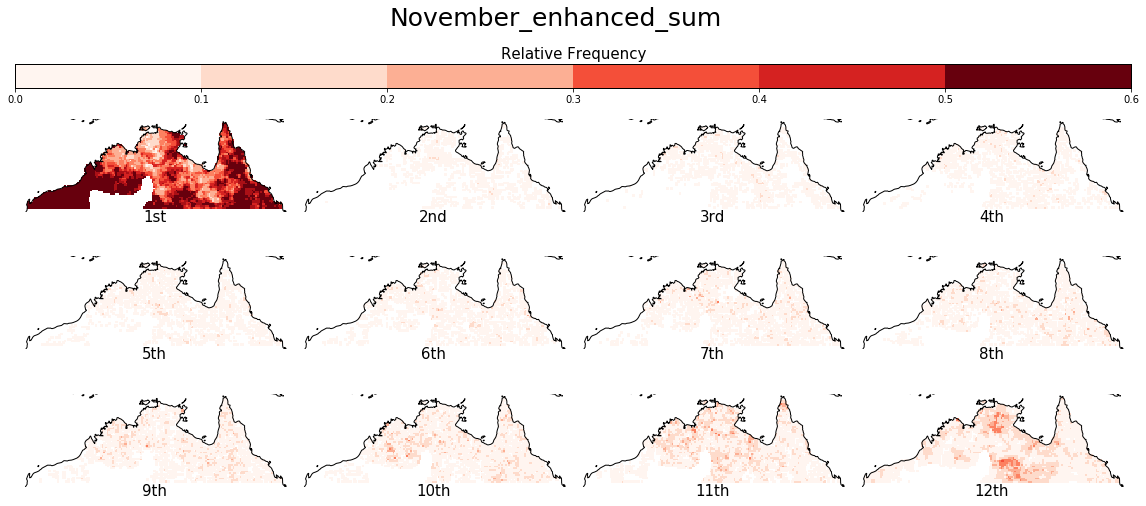

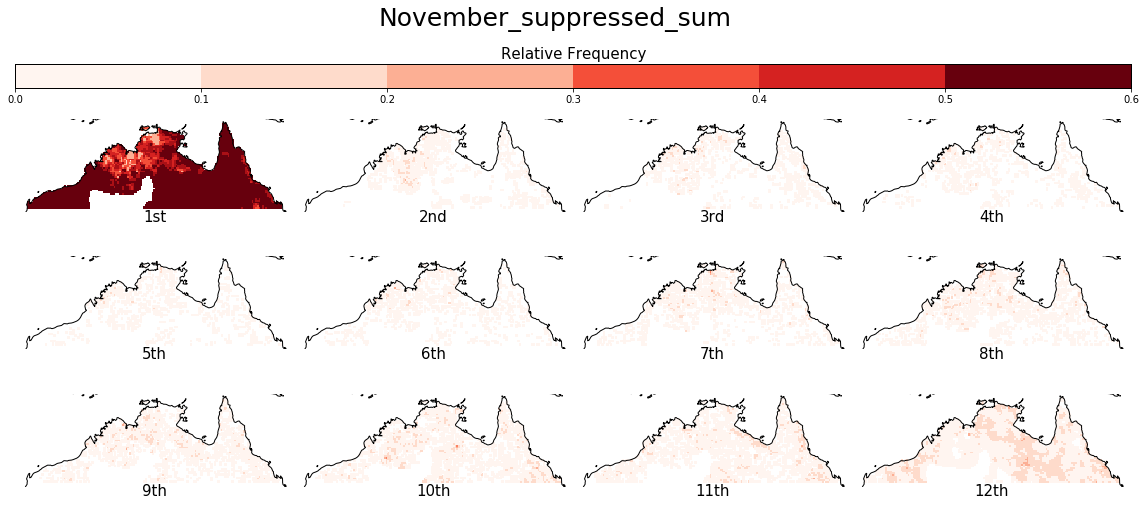

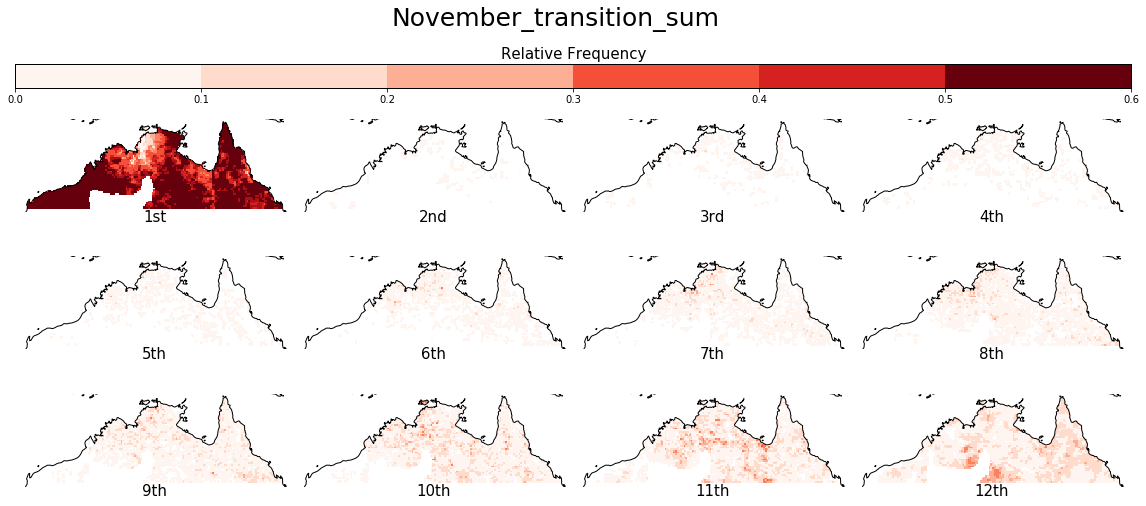

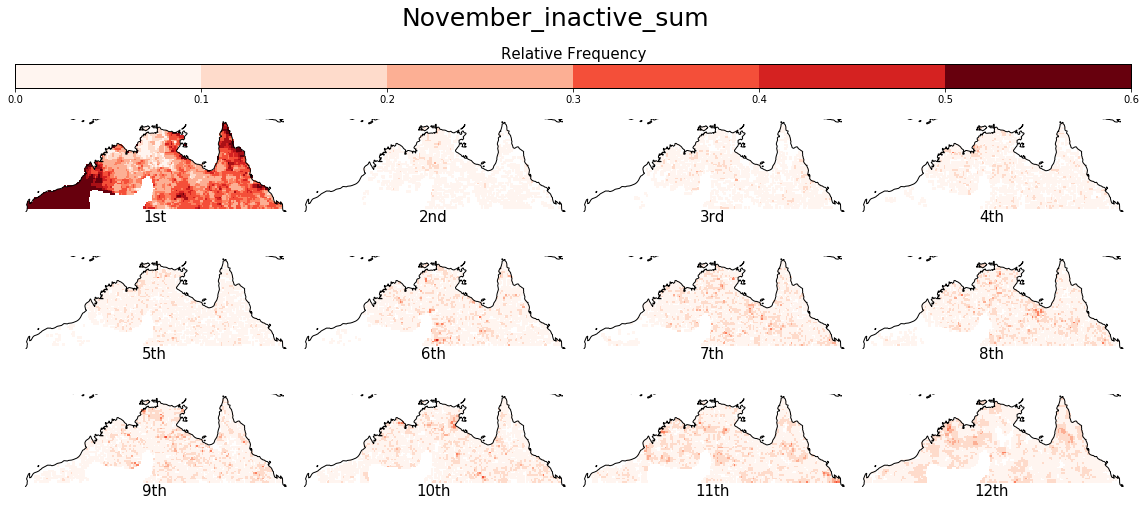

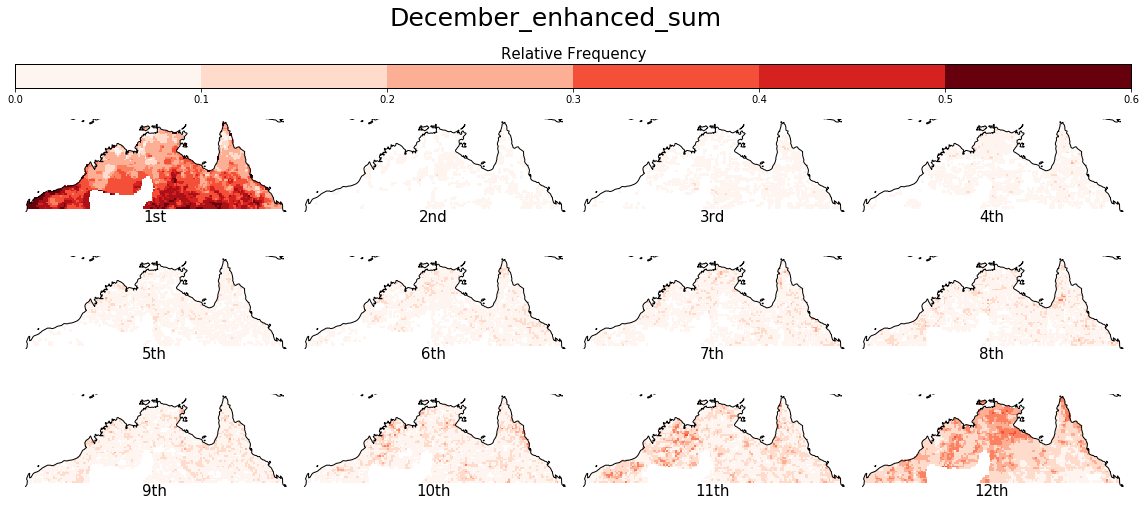

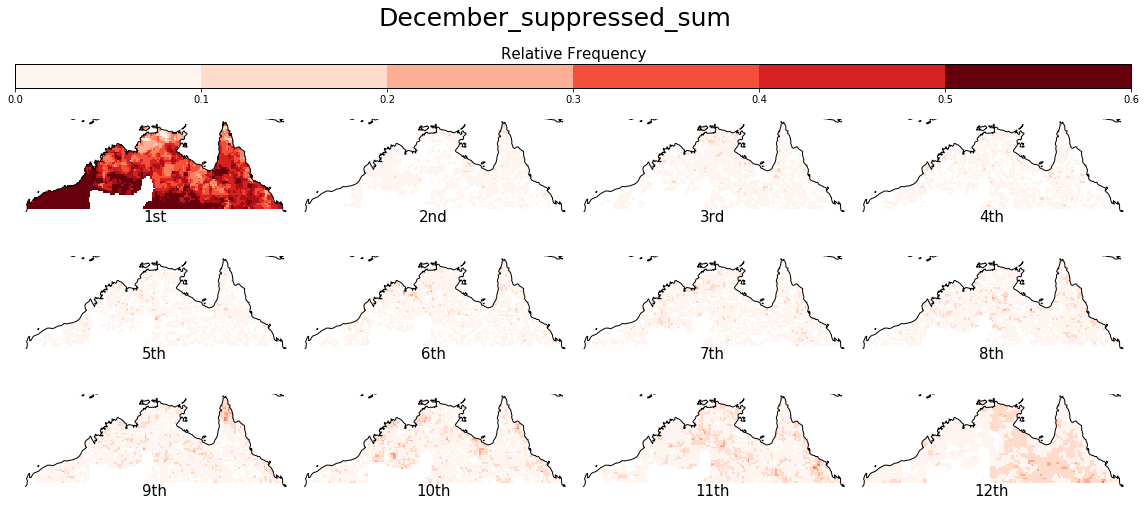

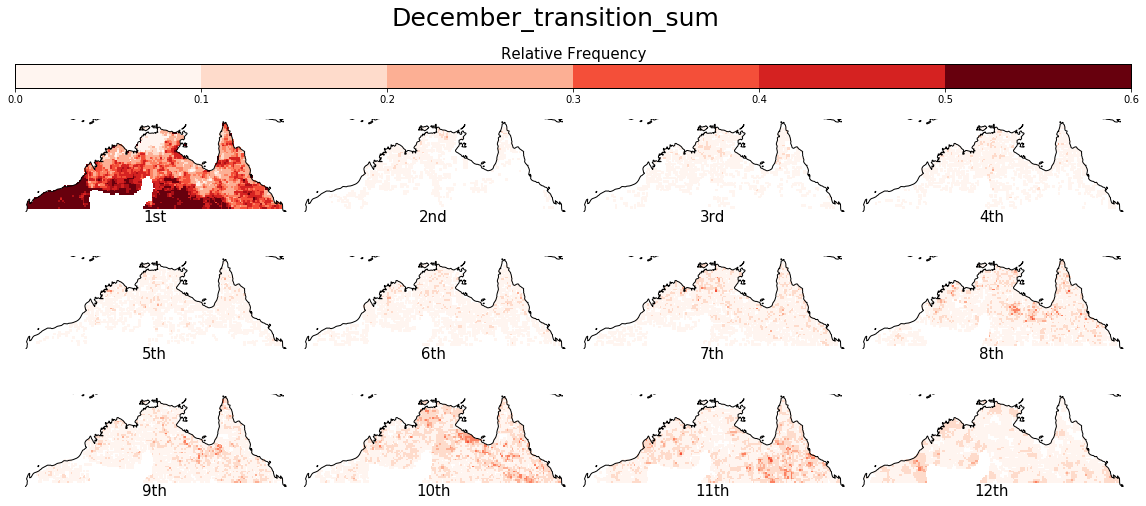

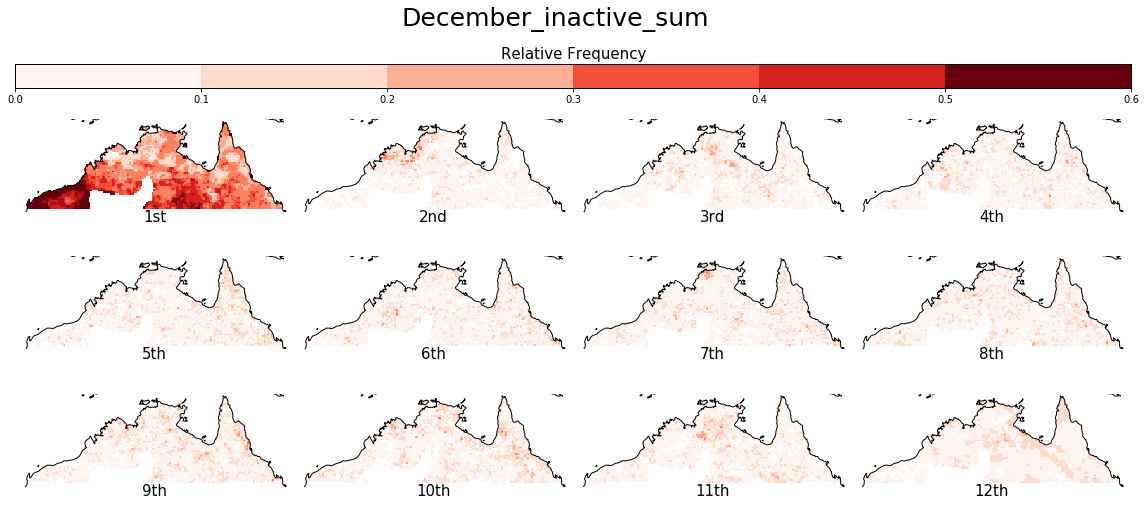

In [189]:
rhpm = reload(rhpm)


for month in rel_freq_int.month.values:
    for phase in rel_freq_int.phase.values:

        save_name = f"{calendar.month_name[month]}_{phase}_sum"
        single_phase = rel_freq_sum.sel(phase = phase, month = month)
        rhpm.rank_maps(single_phase, save_name = save_name, savedir = savedir_sum_1)

## Argmax

In [192]:
np.arange(10,80,10)

array([10, 20, 30, 40, 50, 60, 70])

In [190]:
savedir_sum_2 = savedir_sum + 'argmax/'

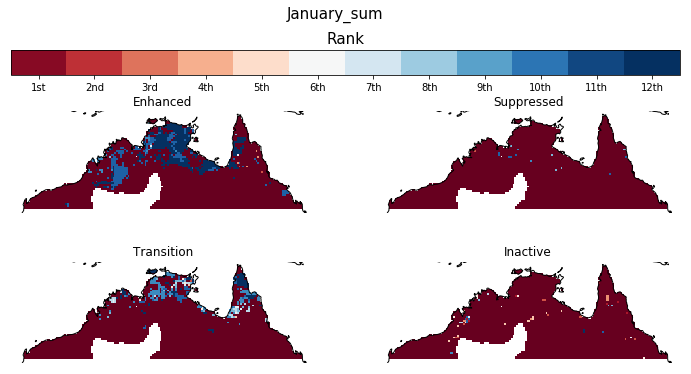

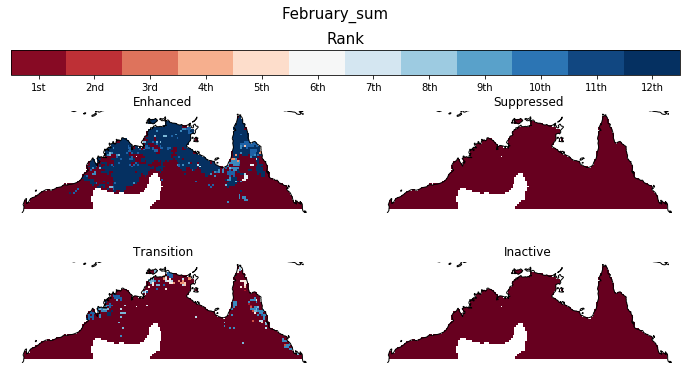

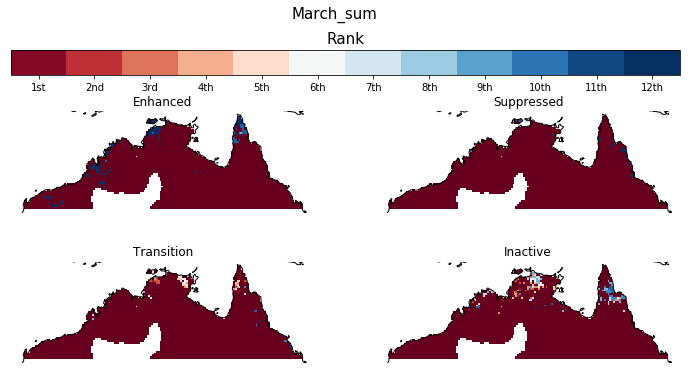

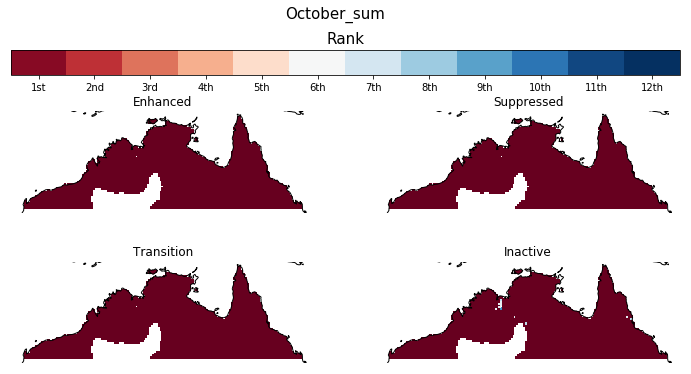

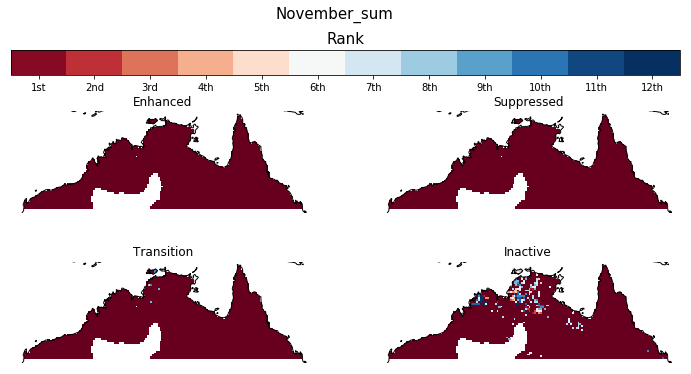

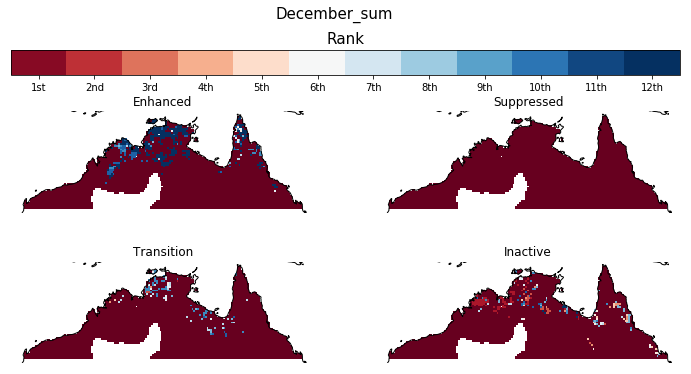

In [191]:
rhpm = reload(rhpm)

for month in argmax.month.values:
    savetitle = f'{calendar.month_name[month]}_sum'
    rhpm.argmax_map_plot(argmax_sum.sel(month = month), savetitle = savetitle, savedir = savedir_sum_2)

# Extremes